# **DELE CA1 Part A**

Name: Lim Zhen Yang

Admission Number: 2214506

Class: DAAA/FT/2B/04


**All imports**


In [24]:
import os
import cv2
import math
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
from collections import defaultdict
from keras_tuner.tuners import RandomSearch
from keras_tuner import RandomSearch, HyperParameters
from imblearn.over_sampling import SMOTE
from keras.models import Sequential, Model, load_model
from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperModel, HyperParameters
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
    Input,
    Add,
    Activation,
    AveragePooling2D,
)
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    fbeta_score,
    accuracy_score,
)
from keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

Check and limit GPU usage


In [25]:
# Check if TensorFlow can access GPUs
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
else:
    print("No GPU devices found. TensorFlow will use CPU.")

Default GPU Device: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


# **BACKGROUND RESEARCH**


### VegNet Dataset for Machine Learning Applications

There have been efforts put into image classification on vegetables. Most noteably, VegNet, which is a dataset of images of vegetables in different qualities. E.g. Ripe, Dried, Damaged, etc...

https://www.sciencedirect.com/science/article/pii/S2352340922008629

Another dataset from Kaggle, named Vegetable Image Dataset, consists of 21,000 colored images covering 15 types of vegetables. It has a very similar dataset to ours.

https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset



### Deep Convolutional Neural Network (DCNN) and Image Classification

Extensive research has been conducted using various plant datasets, including fruits and vegetables, for tasks like image augmentation, segmentation, detection, and classification​​.

https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study

A specific DCNN model reached an accuracy rate of 92.1% on a vegetable image dataset, a significant improvement over the SVM classifier's 80.5% accuracy rate​​.

https://www.nature.com/articles/s41438-021-00560-9

### Hybrid Deep Learning-Based Approaches
Hybrid deep learning-based frameworks, such as attention-based densely connected convolutional networks, are being developed for precise fruit and vegetable classification​​.

https://link.springer.com/article/10.1007/s40747-020-00192-x#:~

### Vegetable Recognition and Classification

Another study involved training images on the VGG-M-BN network, selecting subsets of images ranging from 1,500 to 24,000 from a total of 48,000 vegetable images for classification tasks​​.

https://www.researchgate.net/publication/341843391_Vegetable_Recognition_and_Classification_Based_on_Improved_VGG_Deep_Learning_Network_Model#:~:text=vegetable%20image%20classification%20and%20the,network%20fro%20m%2048000%20veg

# **DATA EXPLORATION**


### **LOADING DATA INTO DATAFRAME**


In [26]:
def dir_to_df(data_dir):
    filepaths = []
    labels = []

    for dir in os.listdir(data_dir):
        for filepath in os.listdir(os.path.join(data_dir, dir)):
            labels.append(dir)
            filepaths.append(os.path.join(data_dir, dir, filepath))

    return pd.DataFrame(list(zip(filepaths, labels)), columns=["filepath", "label"])


test_data = dir_to_df(data_dir=r".\Dataset for CA1 part A\test")
train_data = dir_to_df(data_dir=r".\Dataset for CA1 part A\train")
val_data = dir_to_df(data_dir=r".\Dataset for CA1 part A\validation")

In [27]:
print(
    f"The training dataset has {train_data.shape[0]} images and {len(train_data['label'].unique())} classes"
)

The training dataset has 9028 images and 15 classes


### **NUMBER OF SAMPLES**

From the graph below we can see that there is an uneven number of samples for each category in the training data

- Standard approaches would be to
  - adjust the class_weights argument in model.fit, which you can use to make the model learn more from the minority class
  - reducing the size of the majority class
  - or accepting the imbalance. Deep learning can cope with this, it just needs lots more data


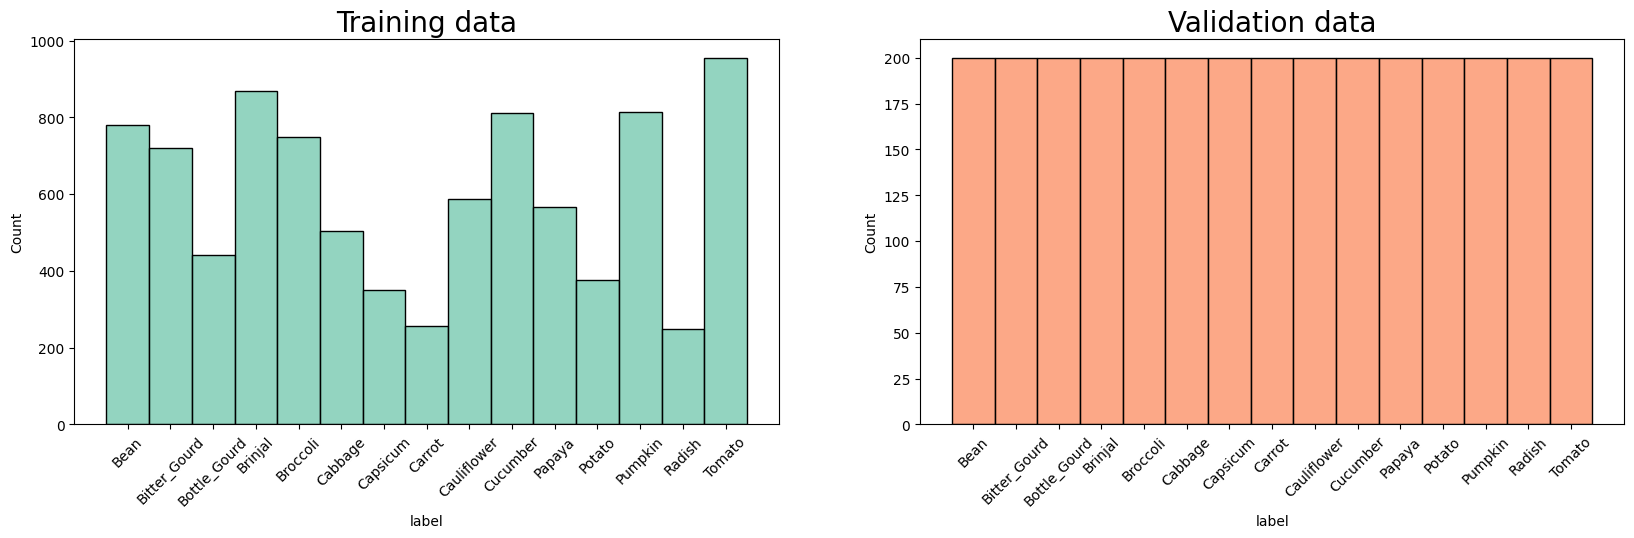

In [28]:
filepath_counts = train_data["label"].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_title("Training data", fontsize=20)
ax2.set_title("Validation data", fontsize=20)
ax1.tick_params(axis="x", rotation=45)
ax2.tick_params(axis="x", rotation=45)

sns.histplot(train_data, x="label", color="#6fc6ab", legend=False, ax=ax1)
sns.histplot(val_data, x="label", color="#fc8b5f", legend=False, ax=ax2)
plt.show()

### **VISUALIZE DATASET**


1. Some images contain one item in frame, and others with more than one item of the same item in frame
2. Some images contain different varients of the same item _(e.g. Capsicum in yellow and red)_

These characteristics of the dataset may make it challenging for the model to isolate specific objects from the image or relate objects of similar characteristics as under the same label

Using grayscale images makes classification even harder for the model, due to the lack of RGB data that would help it _(e.g. Capsicum in yellow and red)_

In [29]:
# Loading images

training_gen = ImageDataGenerator(
    rescale=1 / 255
)  # divides pixel values by 255 to make it within [0, 1]

# Loading training data
train_gen = training_gen.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    class_mode="sparse",
    color_mode="grayscale",
    shuffle=True,
    batch_size=16,
)

Found 9028 validated image filenames belonging to 15 classes.


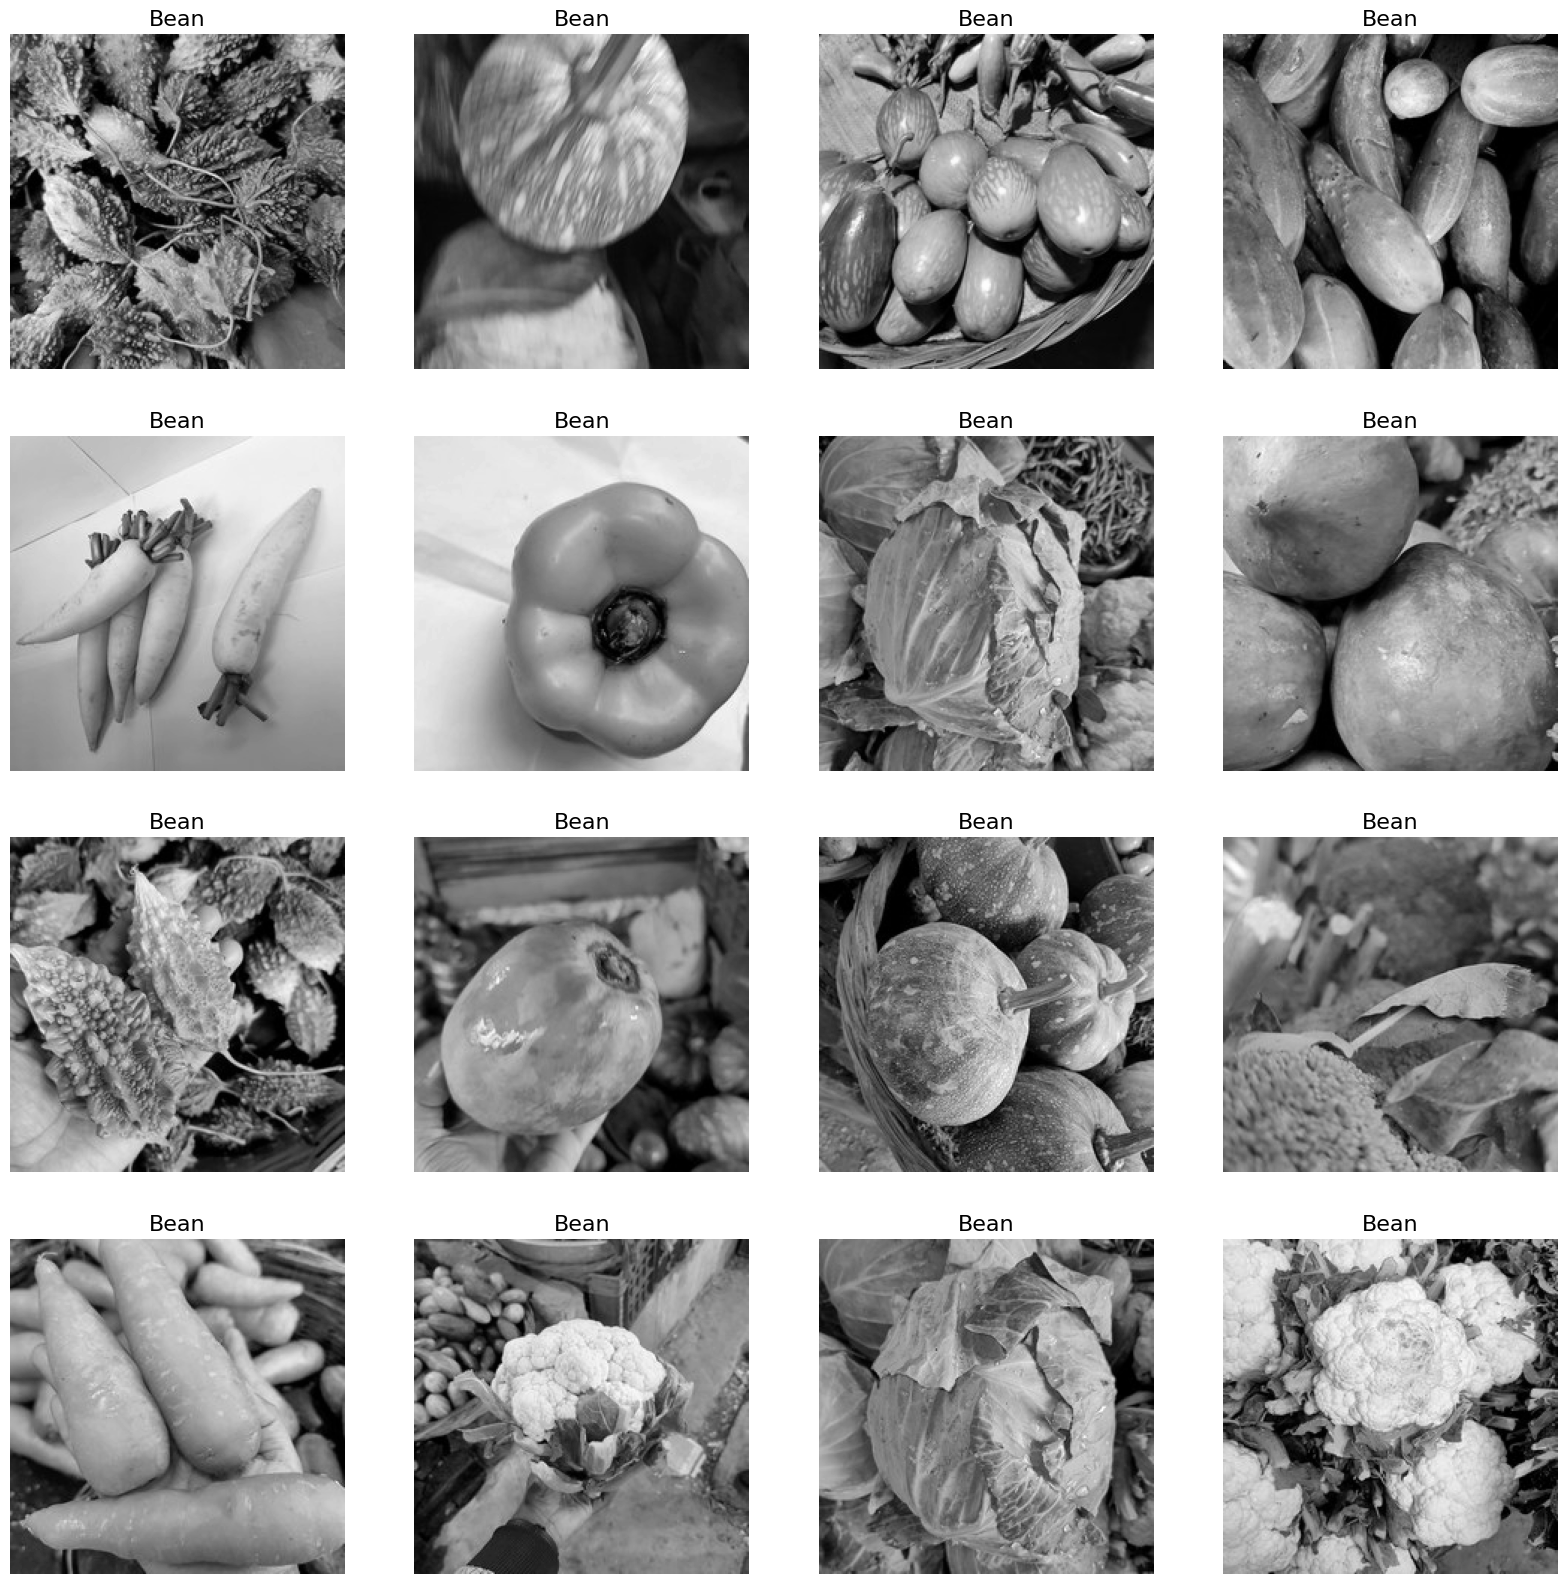

In [30]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(
    g_dict.keys()
)  # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]  # scales data to range (0 - 1)
    plt.imshow(image, cmap='gray')
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, fontsize=16)
    plt.axis("off")

plt.show()

### **IMAGE AVERAGING**

Image Averaging involves stacking multiple photos on top of each other and averaging them together. The main purpose is to see the noise of the image and therefore reducing it.


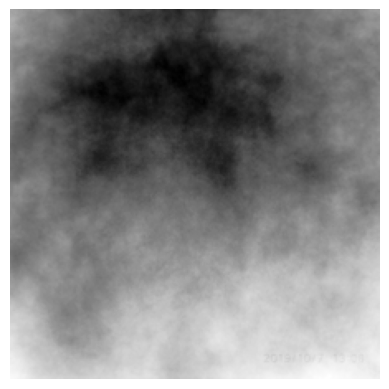

In [31]:
# Initialize an empty list to store the images
images = []

# Get the number of batches in the generator
num_batches = len(train_gen)

# Iterate through each batch and collect the images
for _ in range(num_batches):
    batch = train_gen.next()  # Get the next batch
    batch_images = batch[0]  # The first element of the batch contains the images
    images.append(batch_images)

# Concatenate the list of batches into a single numpy array
all_images = np.concatenate(images, axis=0)

plt.imshow(np.mean(all_images, axis=0), cmap="Greys")
plt.axis("off")
plt.show()

Theres a dark spot at the top of the image. This shows that there are more images at the top of the image compared to anywhere else. 

The rest of the image is mostly gray, which shows that these images may not follow a specific pattern.

# **DATA PREPARATION**


In [32]:
DEFAULT_SHAPE = (224, 224)  # Original image size

### **OVERSAMPLING**


#### **Oversampling to get new images**
Using SMOTE to oversample

In [33]:
data = []
labels = []

data_dir = "./Dataset for CA1 part A/train"
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, DEFAULT_SHAPE)  # Resize to a desired size
        data.append(image)
        labels.append(label)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape data into a 2D format
data_flattened = data.reshape(data.shape[0], -1)

# Apply random oversampling
oversampler = SMOTE(sampling_strategy="all", random_state=42)
data_resampled, labels_resampled = oversampler.fit_resample(data_flattened, labels)

#### **Writing new images to oversampling folder**


In [34]:
output_dir = "./oversampled_images"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
else:
    os.makedirs(output_dir)

for i, (image_data, label) in enumerate(zip(data_resampled, labels_resampled)):
    # Reshape the flattened image data back to its original shape
    image = image_data.reshape((*DEFAULT_SHAPE, 3))

    # Create a subdirectory for each class label if it doesn't exist
    class_output_dir = os.path.join(output_dir, label)
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Save the image with a unique filename
    image_filename = os.path.join(class_output_dir, f"{i}.png")
    cv2.imwrite(image_filename, image)

##### **Convert to DataFrame**


In [35]:
# The numbers of images after each class is now equal at 929
train_data_oversampled = dir_to_df(
    data_dir=r"./oversampled_images"
)  # Convert directory to dataframe
train_data_oversampled.value_counts(["label"])

label       
Bean            955
Bitter_Gourd    955
Bottle_Gourd    955
Brinjal         955
Broccoli        955
Cabbage         955
Capsicum        955
Carrot          955
Cauliflower     955
Cucumber        955
Papaya          955
Potato          955
Pumpkin         955
Radish          955
Tomato          955
Name: count, dtype: int64

### **UNDERSAMPLING**


#### **Undersampling to get less images**


In [36]:
data = []
labels = []

data_dir = "./Dataset for CA1 part A/train"
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, DEFAULT_SHAPE)  # Resize to a desired size
        data.append(image)
        labels.append(label)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape data into a 2D format
data_flattened = data.reshape(data.shape[0], -1)

# Apply random oversampling
oversampler = RandomUnderSampler(sampling_strategy="all", random_state=42)
data_resampled, labels_resampled = oversampler.fit_resample(data_flattened, labels)

#### **Updating images to undersampling folder**


In [37]:
output_dir = "./undersampled_images"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
else:
    os.makedirs(output_dir)

for i, (image_data, label) in enumerate(zip(data_resampled, labels_resampled)):
    # Reshape the flattened image data back to its original shape
    image = image_data.reshape((*DEFAULT_SHAPE, 3))

    # Create a subdirectory for each class label if it doesn't exist
    class_output_dir = os.path.join(output_dir, label)
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Save the image with a unique filename
    image_filename = os.path.join(class_output_dir, f"{i}.png")
    cv2.imwrite(image_filename, image)

##### **Convert to DataFrame**


In [38]:
# The numbers of images after each class is now equal at 929
train_data_undersampled = dir_to_df(
    data_dir=r"./undersampled_images"
)  # Convert directory to dataframe
train_data_undersampled.value_counts(["label"])

label       
Bean            248
Bitter_Gourd    248
Bottle_Gourd    248
Brinjal         248
Broccoli        248
Cabbage         248
Capsicum        248
Carrot          248
Cauliflower     248
Cucumber        248
Papaya          248
Potato          248
Pumpkin         248
Radish          248
Tomato          248
Name: count, dtype: int64

### **IMAGE DATA GENERATOR**

It ensures that our model will receive variation in data at each epoch, which helps **prevent overfitting**. At the same time, the ImageDataGenerator uses **less memory** as it loads all the images in batches rather than all at once.

In [39]:
INPUT_SHAPE_128 = (128, 128)
INPUT_SHAPE_31 = (31, 31)
BATCH_SIZE = 32

### Data Augmentation

- Rotation: Images of vegetables taken will not always be taken exactly vertically, therefore this covers the cases of tilted images.

- Width Shift: Images of vegetables taken will not always be centered, so this accounts for the left and right shift of the image.
- Height Shift: Images of vegetables taken will not always be centered, so this accounts for the top and bottom shift of the image.
- Zoom Range: Images of vegetables may be taken from different distances, which would affect the size of the item in the image.
- Horizontal Flip: Images may be inverted.
- Vertical Flip: Images may be flipped.
- Brightness Range: Vegetables may be dimly lit.

Data augmentation not only covers these cases but also prevents overfitting by testing the model on non-augmented images it has not seen before.

In [40]:
test_gen_format = ImageDataGenerator(rescale=1 / 255)  # Generator for test/validation

# Generator for training data (with augmentation)
train_gen_augment = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=20,  # rotation
    width_shift_range=0.1,  # horizontal shift
    height_shift_range=0.1,  # vertical shift
    zoom_range=0.2,  # zoom
    horizontal_flip=True,  # horizontal flip
    brightness_range=[0.5, 1.5], # brightness
    vertical_flip=True, # vertical flip
)  

# Generator for training data (no augmentation)
train_gen_no_augment = ImageDataGenerator(rescale=1 / 255)

# Loading validation data
def validation_generator(input_shape):
    return test_gen_format.flow_from_dataframe(
        val_data,
        x_col="filepath",
        y_col="label",
        target_size=input_shape,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        batch_size=BATCH_SIZE,
    )

# **MODEL TRAINING**
For each model, I will be testing 128x128 and 31x31 image sizes

### **Optimizers**


There are a lot of different types of optimizers offered by Tensorflow. The most common 2 are Adam and SGD optimizers.

**Adam**

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

**SGD**

SGD also known as Stochastic gradient descent is an iterative method for optimizing an objective function with suitable smoothness.

**Difference between Adam and SGD**

Adam outperforms SGD in terms of speed, thanks to its utilization of coordinate-wise gradient clipping, which addresses heavy-tailed noise. Additionally, Adam adjusts the learning rate for each network weight individually. However, it's worth noting that SGD is recognized for its superior performance in image classification tasks. While Adam may take "shortcuts," which is advantageous for NLP and other applications, in the realm of image classification, the ability to discern every detail is crucial. Hence, for all upcoming models, we will employ SGD as our chosen optimizer.


### **Callbacks**


**EarlyStopping:**

- Monitors a metric during training and stops the training process if the metric stops improving. Helps prevent overfitting.

**LearningRateScheduler:**

- Allows dynamic learning rate scheduling during training based on a provided function.

**ModelCheckpoint:**

- Saves the model's weights at specified intervals during training for later loading and evaluation.

**ReduceLROnPlateau:**

- Reduces the learning rate when a metric has stopped improving. Often used in conjunction with EarlyStopping.


In [41]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate


lr_scheduler = LearningRateScheduler(step_decay)


def model_checkpoint(file):
    return ModelCheckpoint(
        filepath=f"./best weights/{file}",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    )


early_stop = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True, mode="max"
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=3, min_lr=0.0000001
)

tensorboard = TensorBoard(log_dir="./logs")

##### **Utils**


In [42]:
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "b-o", label="Training Accuracy")
    plt.plot(epochs, val_acc, "g-x", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.ylim([0, 1])

    # Dynamic x-axis ticks
    tick_spacing = max(1, len(epochs) // 10)
    plt.xticks(epochs[::tick_spacing])

    max_val_acc = max(val_acc)
    plt.text(
        len(epochs) * 0.8,
        max_val_acc * 1.01,
        f"Max Val Acc: {max_val_acc:.4f}",
        fontsize=9,
    )

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "b-o", label="Training Loss")
    plt.plot(epochs, val_loss, "g-x", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Dynamic x-axis ticks for loss plot
    plt.xticks(epochs[::tick_spacing])

    min_val_loss = min(val_loss)
    plt.text(
        len(epochs) * 0.8,
        min_val_loss * 1.01,
        f"Min Val Loss: {min_val_loss:.4f}",
        fontsize=9,
    )

    plt.tight_layout()
    plt.show()

allResults = pd.DataFrame()
def storeResult(modelInfo, description="No augmentation or regularization"):
    history = modelInfo.history
    best_val_idx = np.argmax(history["val_accuracy"])
    result = {}
    result["Model Name"] = modelInfo.model._name
    result["Description"] = description
    result["Epochs"] = len(history["loss"])
    result["Batch Size"] = BATCH_SIZE
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Val Loss"] = history["val_loss"][best_val_idx]
    result["Train Acc"] = history["accuracy"][best_val_idx]
    result["Val Acc"] = history["val_accuracy"][best_val_idx]
    result["[Train - Val] Acc"] = result["Train Acc"] - result["Val Acc"]
    result = pd.DataFrame([result])
    global allResults
    allResults = pd.concat([allResults, result], ignore_index=True)
    return result


def reset_model(model):
    if model:
        del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

Number of unique classes

In [43]:
# Setting constants
NUM_CLASSES = len(train_gen.class_indices)

### **BASE MODEL**

> A simple control to compare with our robust models


In [8]:
def instantiate_base_model(input_shape, name="base_model"):
    base_model = Sequential(name=name)
    base_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(*input_shape, 1)))
    base_model.add(MaxPooling2D((2, 2)))
    base_model.add(Conv2D(64, (3, 3), activation="relu"))
    base_model.add(MaxPooling2D((2, 2)))
    base_model.add(Flatten())
    base_model.add(Dense(NUM_CLASSES, activation="softmax"))

    base_model.compile("sgd", loss="categorical_crossentropy", metrics=["accuracy"])
    return base_model


base_model = instantiate_base_model(DEFAULT_SHAPE)
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 15)                2

#### **BASE MODEL (128x128) (OVERSAMPLED)**


Found 14325 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
447/447 [==============================] - 144s 267ms/step - loss: 2.5019 - accuracy: 0.2005 - val_loss: 2.1302 - val_accuracy: 0.3427 - lr: 0.1000
Epoch 2/100
447/447 [==============================] - 27s 61ms/step - loss: 1.8774 - accuracy: 0.4379 - val_loss: 1.7165 - val_accuracy: 0.4916 - lr: 0.1000
Epoch 3/100
447/447 [==============================] - 29s 64ms/step - loss: 1.1838 - accuracy: 0.6551 - val_loss: 1.5867 - val_accuracy: 0.5696 - lr: 0.1000
Epoch 4/100
447/447 [==============================] - 27s 61ms/step - loss: 0.6095 - accuracy: 0.8213 - val_loss: 1.6378 - val_accuracy: 0.5914 - lr: 0.1000
Epoch 5/100
447/447 [==============================] - 27s 61ms/step - loss: 0.2498 - accuracy: 0.9295 - val_loss: 1.8355 - val_accuracy: 0.6156 - lr: 0.1000
Epoch 6/100
447/447 [==============================] - 27s 61ms/step - loss: 0.0993

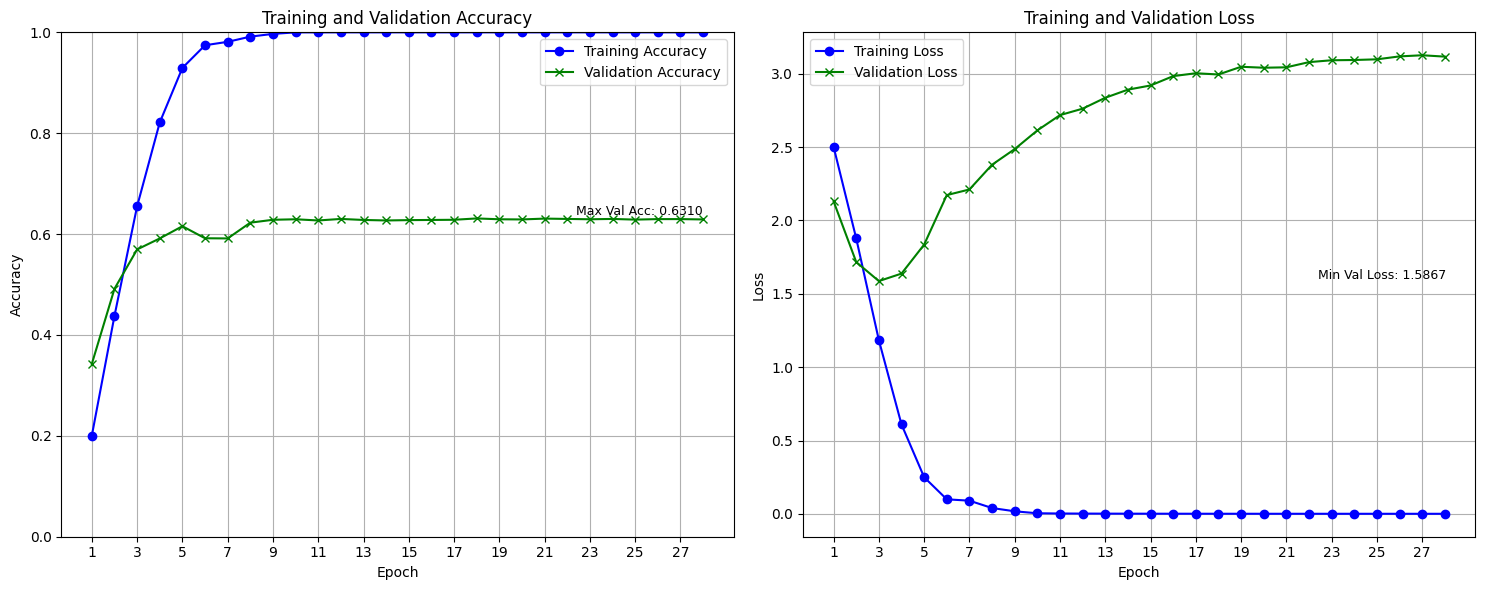

In [47]:
reset_model(base_model)

train_gen_oversampled = train_gen_no_augment.flow_from_dataframe(
    train_data_oversampled,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

N_STEPS = train_gen_oversampled.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_128)

base_model_oversampled_history = base_model.fit(
    train_gen_oversampled,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[early_stop, reduce_lr, lr_scheduler, tensorboard],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_oversampled_history, description="128x128 oversampled")
plot_history(base_model_oversampled_history)

1. There might be a need for regularization techniques, data augmentation, or a review of the model's complexity to address overfitting.
2. The peak validation accuracy is decent but might need improvement, which could involve tuning hyperparameters, collecting more data, or trying different model architectures.
3. Validation loss increasing after just 3 epochs shows the model memorizing training data, not generalizing to validation data.

#### **BASE MODEL (31x31) (OVERSAMPLED)**


Found 14325 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
447/447 [==============================] - 26s 58ms/step - loss: 2.5895 - accuracy: 0.1506 - val_loss: 2.2788 - val_accuracy: 0.2826 - lr: 0.1000
Epoch 2/100
447/447 [==============================] - 25s 57ms/step - loss: 2.1993 - accuracy: 0.3168 - val_loss: 1.8952 - val_accuracy: 0.4298 - lr: 0.1000
Epoch 3/100
447/447 [==============================] - 25s 57ms/step - loss: 1.8748 - accuracy: 0.4193 - val_loss: 1.6358 - val_accuracy: 0.5074 - lr: 0.1000
Epoch 4/100
447/447 [==============================] - 26s 57ms/step - loss: 1.5830 - accuracy: 0.5234 - val_loss: 1.3653 - val_accuracy: 0.5877 - lr: 0.1000
Epoch 5/100
447/447 [==============================] - 26s 58ms/step - loss: 1.3264 - accuracy: 0.5983 - val_loss: 1.2950 - val_accuracy: 0.6142 - lr: 0.1000
Epoch 6/100
447/447 [==============================] - 26s 58ms/step - loss: 1.1228 -

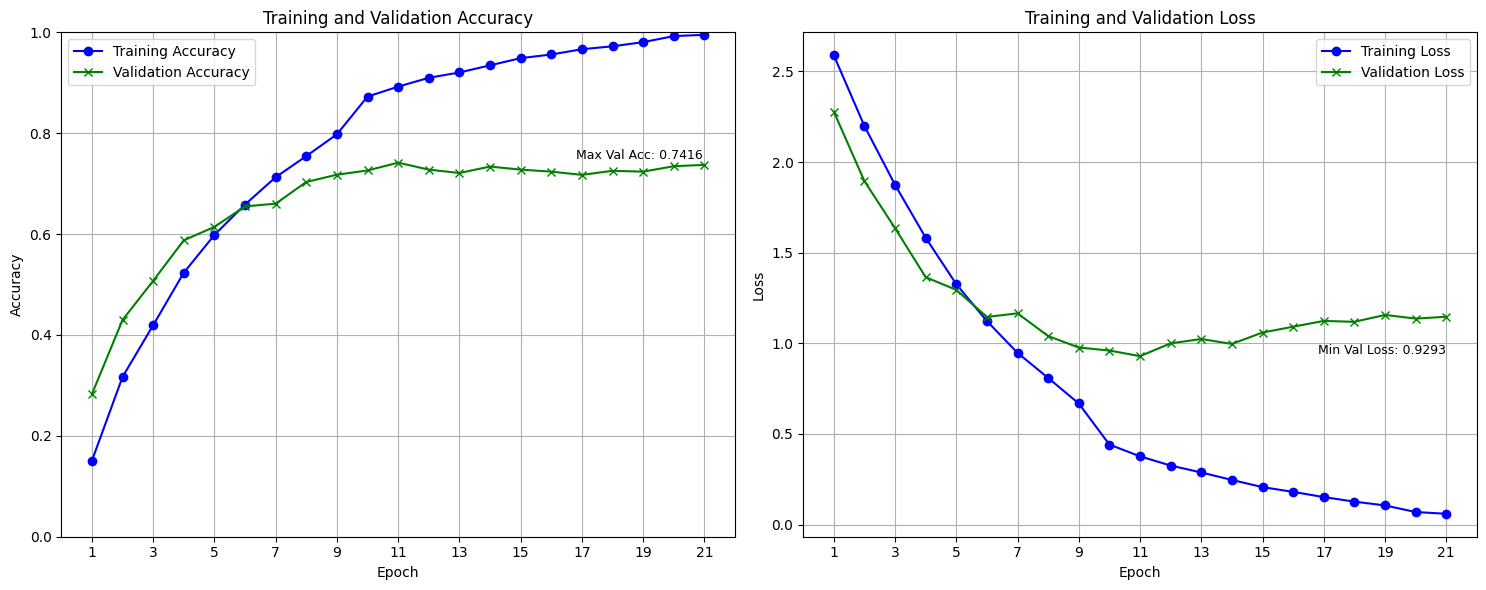

In [48]:
reset_model(base_model)

train_gen_oversampled = train_gen_no_augment.flow_from_dataframe(
    train_data_oversampled,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

N_STEPS = train_gen_oversampled.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_31)

base_model_oversampled_history = base_model.fit(
    train_gen_oversampled,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[early_stop, reduce_lr, lr_scheduler, tensorboard],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_oversampled_history, description="31x31 oversampled")
plot_history(base_model_oversampled_history)

1. There might be a need for regularization techniques, data augmentation, or a review of the model's complexity to address overfitting.
2. The peak validation accuracy is decent but might need improvement, which could involve tuning hyperparameters, collecting more data, or trying different model architectures.
3. Compared to 128x128, this smaller image size performed way better on this model. This is likely because this small CNN model was able to generalize to the small images compared to the bigger 128x128 images.

#### **BASE MODEL (128x128) (UNDERSAMPLED)**


Found 3720 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
116/116 [==============================] - 142s 1s/step - loss: 2.6739 - accuracy: 0.1106 - val_loss: 2.6478 - val_accuracy: 0.0662 - lr: 0.1000
Epoch 2/100
116/116 [==============================] - 140s 1s/step - loss: 2.4049 - accuracy: 0.2343 - val_loss: 2.5279 - val_accuracy: 0.1966 - lr: 0.1000
Epoch 3/100
116/116 [==============================] - 138s 1s/step - loss: 2.1207 - accuracy: 0.3587 - val_loss: 2.0560 - val_accuracy: 0.3760 - lr: 0.1000
Epoch 4/100
116/116 [==============================] - 131s 1s/step - loss: 1.5675 - accuracy: 0.5247 - val_loss: 1.8744 - val_accuracy: 0.4422 - lr: 0.1000
Epoch 5/100
116/116 [==============================] - 134s 1s/step - loss: 0.9819 - accuracy: 0.7099 - val_loss: 1.7033 - val_accuracy: 0.5208 - lr: 0.1000
Epoch 6/100
116/116 [==============================] - 138s 1s/step - loss: 0.4924 - accura

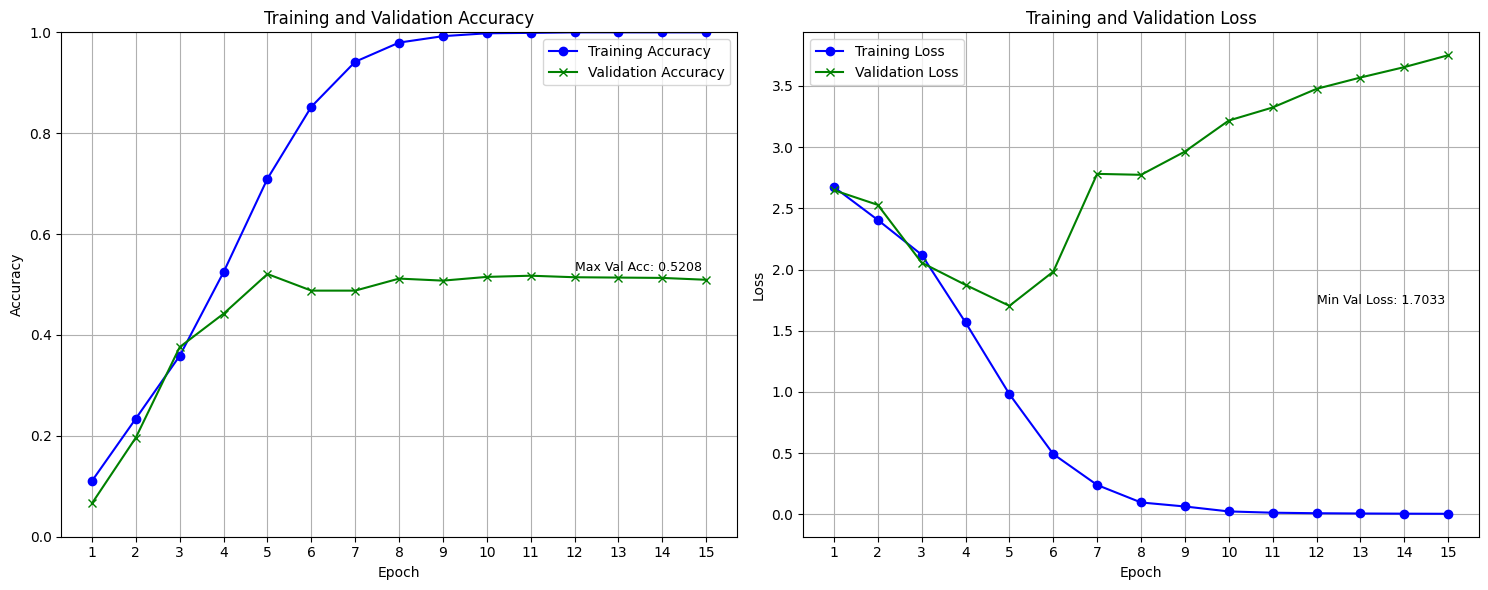

In [49]:
reset_model(base_model)

train_gen_undersampled = train_gen_no_augment.flow_from_dataframe(
    train_data_undersampled,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

N_STEPS = train_gen_undersampled.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_128)

base_model_undersampled_history = base_model.fit(
    train_gen_undersampled,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[early_stop, reduce_lr, lr_scheduler, tensorboard],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_undersampled_history, description="128x128 undersampled")
plot_history(base_model_undersampled_history)

1. There might be a need for regularization techniques, data augmentation, or a review of the model's complexity to address overfitting.
2. The peak validation accuracy is fair, it needs improvement, which could involve tuning hyperparameters, or more likely trying different model architectures.
3. Validation loss increasing after just 5 epochs shows the model memorizing training data, not generalizing to validation data.

#### **BASE MODEL (31x31) (UNDERSAMPLED)**


Found 3720 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
116/116 [==============================] - 9s 74ms/step - loss: 2.6949 - accuracy: 0.0865 - val_loss: 2.6594 - val_accuracy: 0.1072 - lr: 0.1000
Epoch 2/100
116/116 [==============================] - 8s 71ms/step - loss: 2.5681 - accuracy: 0.1708 - val_loss: 2.6360 - val_accuracy: 0.0998 - lr: 0.1000
Epoch 3/100
116/116 [==============================] - 8s 72ms/step - loss: 2.3743 - accuracy: 0.2454 - val_loss: 2.3185 - val_accuracy: 0.2423 - lr: 0.1000
Epoch 4/100
116/116 [==============================] - 9s 74ms/step - loss: 2.1565 - accuracy: 0.3294 - val_loss: 2.0205 - val_accuracy: 0.3757 - lr: 0.1000
Epoch 5/100
116/116 [==============================] - 8s 71ms/step - loss: 2.0109 - accuracy: 0.3799 - val_loss: 1.9562 - val_accuracy: 0.4022 - lr: 0.1000
Epoch 6/100
116/116 [==============================] - 8s 72ms/step - loss: 1.8094 - accura

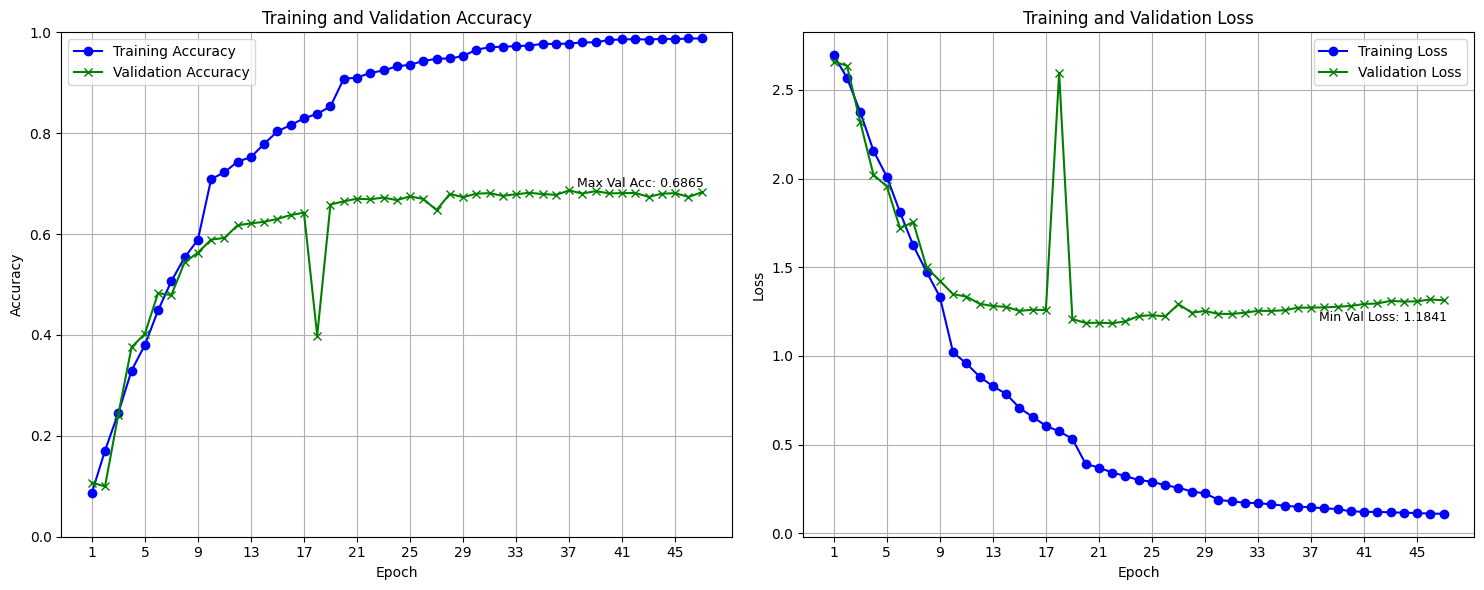

In [50]:
reset_model(base_model)

train_gen_undersampled = train_gen_no_augment.flow_from_dataframe(
    train_data_undersampled,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

N_STEPS = train_gen_undersampled.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_31)

base_model_undersampled_history = base_model.fit(
    train_gen_undersampled,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[early_stop, reduce_lr, lr_scheduler, tensorboard],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_undersampled_history, description="31x31 undersampled")
plot_history(base_model_undersampled_history)

1. There might be a need for regularization techniques, data augmentation, or a review of the model's complexity to address overfitting.
2. There is an spike at 17 to 19 epochs
3. Compared to oversampling, validation accuracy is lower, and loss is higher. It seems the decrease in image data made it more difficult for the model to generalize.

#### **BASE MODEL (128x128) (IMBALANCED)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
282/282 [==============================] - 113s 300ms/step - loss: 2.5417 - accuracy: 0.1833 - val_loss: 2.6316 - val_accuracy: 0.1378 - lr: 0.1000
Epoch 2/100
282/282 [==============================] - 10s 36ms/step - loss: 2.1886 - accuracy: 0.3420 - val_loss: 2.1307 - val_accuracy: 0.3555 - lr: 0.1000
Epoch 3/100
282/282 [==============================] - 10s 34ms/step - loss: 1.8714 - accuracy: 0.4396 - val_loss: 2.2810 - val_accuracy: 0.3464 - lr: 0.1000
Epoch 4/100
282/282 [==============================] - 9s 33ms/step - loss: 1.5560 - accuracy: 0.5346 - val_loss: 1.8435 - val_accuracy: 0.4644 - lr: 0.1000
Epoch 5/100
282/282 [==============================] - 10s 34ms/step - loss: 1.3392 - accuracy: 0.5978 - val_loss: 2.0696 - val_accuracy: 0.4224 - lr: 0.1000
Epoch 6/100
282/282 [==============================] - 9s 33ms/step - loss: 0.8836 - 

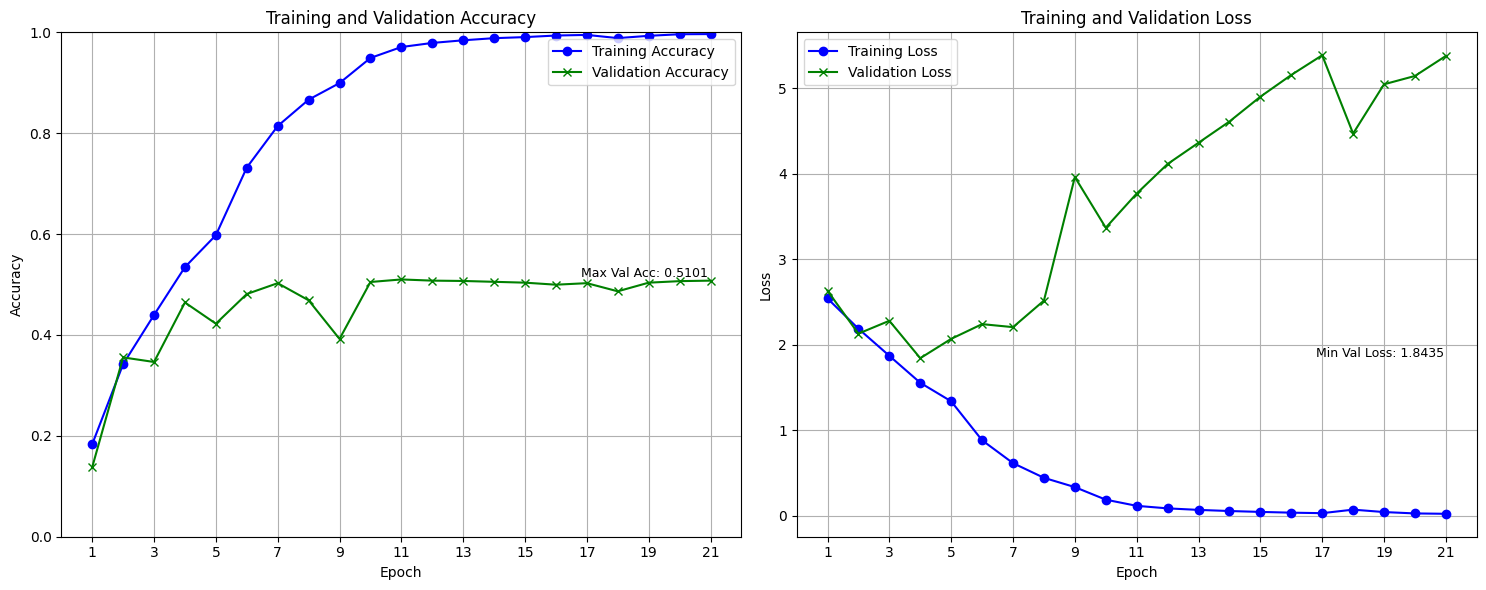

In [12]:
reset_model(base_model)

train_gen_undersampled = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

N_STEPS = train_gen_undersampled.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_128)

base_model_undersampled_history = base_model.fit(
    train_gen_undersampled,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[early_stop, reduce_lr, lr_scheduler, tensorboard],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_undersampled_history, description="128x128 imbalanced")
plot_history(base_model_undersampled_history)

1. Validation accuracy is low, and validation loss in is increasing. This has been a consistent result for 128x128 images for all different sampling techniques trained on the base model. There is most definitely an architecture change that has to be made.

#### **BASE MODEL (31x31) (IMBALANCED)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
282/282 [==============================] - 12s 42ms/step - loss: 2.5194 - accuracy: 0.1735 - val_loss: 2.3781 - val_accuracy: 0.2463 - lr: 0.1000
Epoch 2/100
282/282 [==============================] - 11s 39ms/step - loss: 2.1200 - accuracy: 0.3494 - val_loss: 2.0355 - val_accuracy: 0.3656 - lr: 0.1000
Epoch 3/100
282/282 [==============================] - 11s 38ms/step - loss: 1.7636 - accuracy: 0.4553 - val_loss: 1.6999 - val_accuracy: 0.4590 - lr: 0.1000
Epoch 4/100
282/282 [==============================] - 10s 37ms/step - loss: 1.5005 - accuracy: 0.5355 - val_loss: 1.5691 - val_accuracy: 0.5296 - lr: 0.1000
Epoch 5/100
282/282 [==============================] - 10s 36ms/step - loss: 1.2925 - accuracy: 0.6066 - val_loss: 1.3196 - val_accuracy: 0.5988 - lr: 0.1000
Epoch 6/100
282/282 [==============================] - 10s 36ms/step - loss: 1.1747 - 

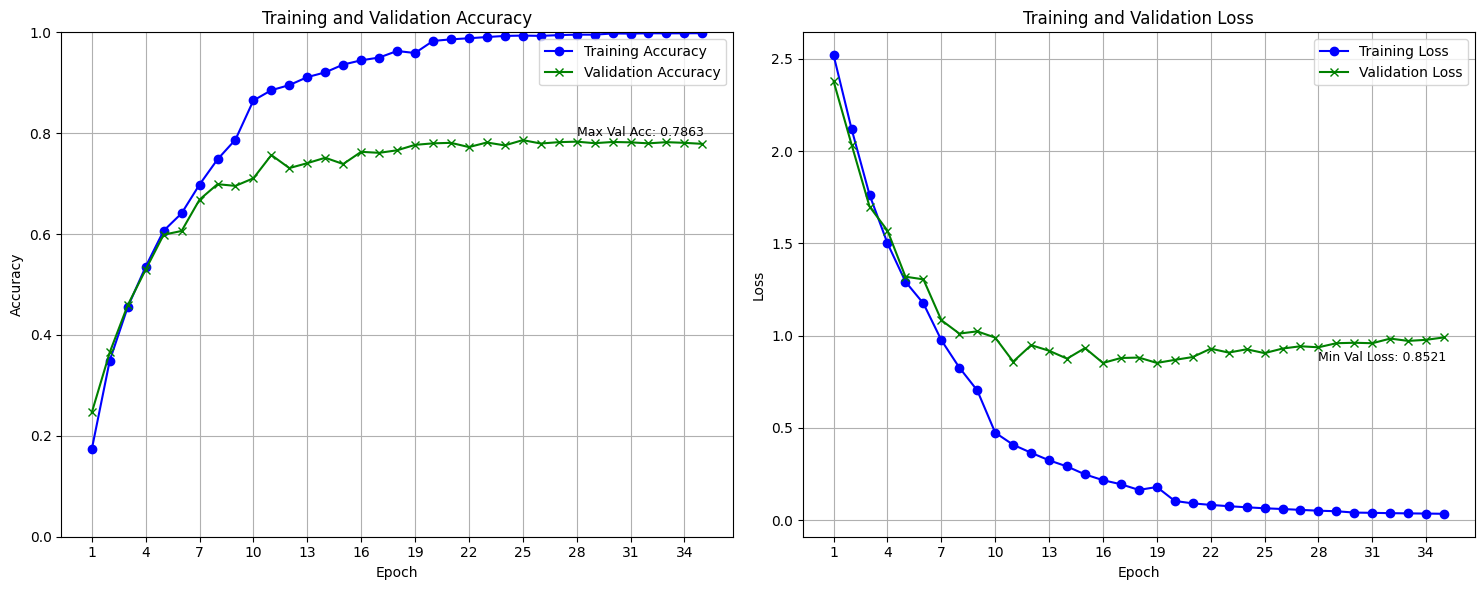

In [52]:
reset_model(base_model)

train_gen_undersampled = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

N_STEPS = train_gen_undersampled.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_31)

base_model_undersampled_history = base_model.fit(
    train_gen_undersampled,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[early_stop, reduce_lr, lr_scheduler, tensorboard],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_undersampled_history, description="31x31 imbalanced")
plot_history(base_model_undersampled_history)

1. There might be a need for regularization techniques, data augmentation, to address overfitting.
2. Imbalanced data performed the best for 31x31 images surprisingly. This demonstrates a neural network's ability to generalize inspite of imbalanced data
3. This smaller CNN architecture seems to work for 31x31.

#### **Observations**

Notice that the distrubution of labels affected our base models very little. It seems deep nureal networks can deal with imbalanced data because the results we got from the imbalanced dataset were the best for 31x31, and there is little difference for 128x128. However, taking a look at the huge difference between training accuracy and validation accuracy, we can see an obvious case of overfitting. Let us try data augmentation, a powerful regularization technique, to solve this issue.

#### **BASE MODEL WITH AUGMENTATION (128x128)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
282/282 [==============================] - 22s 78ms/step - loss: 2.6420 - accuracy: 0.1203 - val_loss: 2.7336 - val_accuracy: 0.1213 - lr: 0.1000
Epoch 2/100
282/282 [==============================] - 22s 78ms/step - loss: 2.5266 - accuracy: 0.1784 - val_loss: 2.5756 - val_accuracy: 0.1683 - lr: 0.1000
Epoch 3/100
282/282 [==============================] - 23s 82ms/step - loss: 2.4073 - accuracy: 0.2185 - val_loss: 2.5592 - val_accuracy: 0.1626 - lr: 0.1000
Epoch 4/100
282/282 [==============================] - 26s 92ms/step - loss: 2.3655 - accuracy: 0.2342 - val_loss: 2.4566 - val_accuracy: 0.2218 - lr: 0.1000
Epoch 5/100
282/282 [==============================] - 25s 88ms/step - loss: 2.2939 - accuracy: 0.2541 - val_loss: 2.2534 - val_accuracy: 0.2927 - lr: 0.1000
Epoch 6/100
282/282 [==============================] - 22s 77ms/step - loss: 2.2222 - 

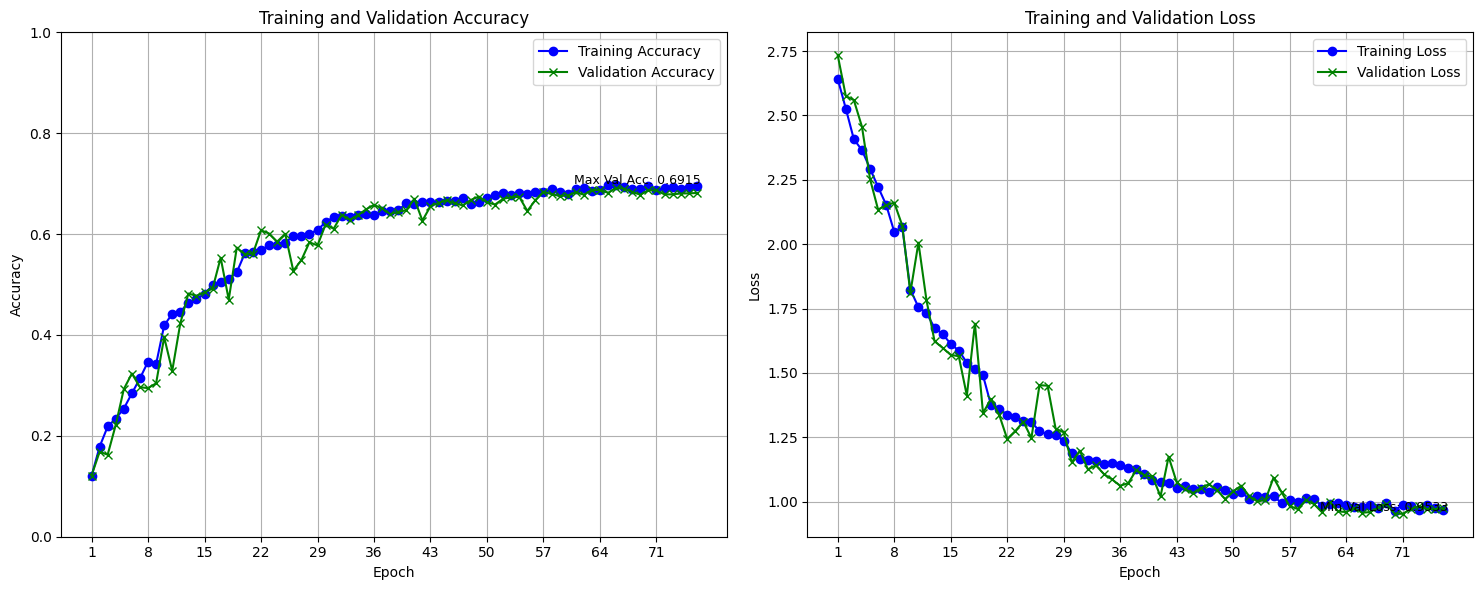

In [53]:
reset_model(base_model)

train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_gen = validation_generator(INPUT_SHAPE_128)

N_STEPS = train_gen.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_128)

base_model_augmented_history = base_model.fit(
    train_gen,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
        tensorboard,
    ],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_undersampled_history, description="128x128 augmented")
plot_history(base_model_augmented_history)

This is amazing. 

With augmentation, our validation results follow training results almost exactly. The model is generalizing to unseen images extremely well. Augmentation works great for 128x128 images. 

However the max validation accuracy is still capped at 0.6915 which is most likely due to the simple architecture. We'll try a more robust model architecture later.

#### **BASE MODEL WITH AUGMENTATION (31x31)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
282/282 [==============================] - 17s 59ms/step - loss: 2.6085 - accuracy: 0.1235 - val_loss: 2.6397 - val_accuracy: 0.1290 - lr: 0.1000
Epoch 2/100
282/282 [==============================] - 16s 57ms/step - loss: 2.5280 - accuracy: 0.1729 - val_loss: 2.6284 - val_accuracy: 0.1267 - lr: 0.1000
Epoch 3/100
282/282 [==============================] - 16s 58ms/step - loss: 2.4706 - accuracy: 0.1923 - val_loss: 2.4971 - val_accuracy: 0.1983 - lr: 0.1000
Epoch 4/100
282/282 [==============================] - 16s 56ms/step - loss: 2.3946 - accuracy: 0.2242 - val_loss: 2.5379 - val_accuracy: 0.1455 - lr: 0.1000
Epoch 5/100
282/282 [==============================] - 16s 58ms/step - loss: 2.3423 - accuracy: 0.2437 - val_loss: 2.4456 - val_accuracy: 0.2251 - lr: 0.1000
Epoch 6/100
282/282 [==============================] - 16s 58ms/step - loss: 2.2734 - 

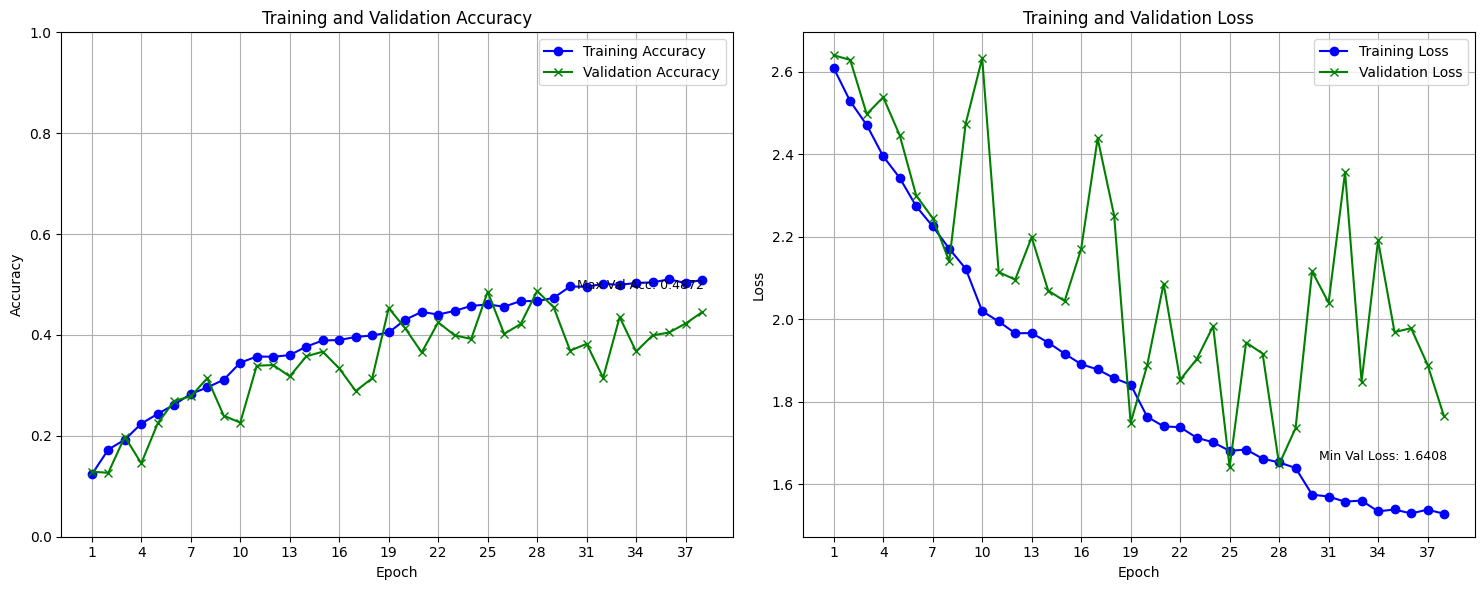

In [54]:
reset_model(base_model)

train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_gen = validation_generator(INPUT_SHAPE_31)

N_STEPS = train_gen.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

base_model = instantiate_base_model(INPUT_SHAPE_31)

base_model_augmented_history = base_model.fit(
    train_gen,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
        tensorboard,
    ],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(base_model_augmented_history, description="31x31 augmented")
plot_history(base_model_augmented_history)

With some data augmentation, our training and validation accuracy follows our training accuracy until it starts to become extremely haphazard, consistently below training accuracy, and validation loss increasing as the number of epochs increased. 

The validation accuracy we got was also significantly lower than without augmentation. We can conclude that data augmentation is not helpful for the 31x31 image sizes.

## **ROBUST MODELS**

> These models are supposed to give us the best performance


### **ADAPTED AlexNet**

AlexNet is a pioneering deep convolutional neural network architecture that made a significant impact on computer vision and deep learning. Developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, it won the 2012 ImageNet Large Scale Visual Recognition Challenge (ILSVRC) by showcasing the advantages of deep architectures. With its eight-layer design, featuring five convolutional layers, AlexNet excelled in capturing hierarchical image features. It introduced innovations like ReLU activations, data augmentation, dropout layers, and GPU acceleration, setting the stage for the deep learning revolution in image recognition and inspiring the development of subsequent advanced neural network architectures.

It was originally trained on 227×227×3 image sizes. I expect our adapted AlexNet to perform well on the 128x128 images, due to its larger kernel size `(11x11)` and large number of filters, giving it more trainable parameters to fit to the 128x128 images that contain more data.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*3B8iO-se13vA2QfZ4OBRSw.png"/>

In [32]:
# Number of neurons in the fully connected layer has been decreased
# Number of Convolutional Layer with ReLU activation has been reduced
# Number of Filters have been reduced
def instantiate_alexnet_model(input_shape):
    # Initialize the adapted_alexnet_model
    adapted_alexnet_model = Sequential(name="alexnet")

    # Layer 1: Convolutional Layer with ReLU activation and Max-Pooling
    adapted_alexnet_model.add(
        Conv2D(
            64,
            (11, 11),
            strides=(4, 4),
            activation="relu",
            input_shape=(*input_shape, 1),
        )
    )
    adapted_alexnet_model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    # Layer 2: Convolutional Layer with ReLU activation and Max-Pooling
    adapted_alexnet_model.add(Conv2D(126, (5, 5), padding="same", activation="relu"))
    adapted_alexnet_model.add(MaxPooling2D((3, 3), strides=(2, 2), padding="same"))

    # Layer 3: Convolutional Layer with ReLU activation
    adapted_alexnet_model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))

    # Layer 5: Convolutional Layer with ReLU activation and Max-Pooling
    adapted_alexnet_model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    adapted_alexnet_model.add(MaxPooling2D((3, 3), strides=(4, 4), padding="same"))

    # Layer 6: Flatten Layer
    adapted_alexnet_model.add(Flatten())

    # Layer 7: Fully Connected Layer with ReLU activation and Dropout
    adapted_alexnet_model.add(Dense(128, activation="relu"))
    adapted_alexnet_model.add(Dropout(0.5))

    # Layer 8: Fully Connected Layer with ReLU activation and Dropout
    adapted_alexnet_model.add(Dense(128, activation="relu"))
    adapted_alexnet_model.add(Dropout(0.5))

    # Layer 9: Fully Connected Layer (Output Layer) with Softmax activation
    adapted_alexnet_model.add(Dense(NUM_CLASSES, activation="softmax"))

    # Compile the adapted_alexnet_model
    adapted_alexnet_model.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return adapted_alexnet_model

adapted_alexnet_model = instantiate_alexnet_model(DEFAULT_SHAPE)
adapted_alexnet_model.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 128)       15616     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 256)       819456    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 512)       1180160   
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 512)       2359

#### **AlexNet (128x128)**

Trained with data augmentation

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
282/282 [==============================] - 28s 96ms/step - loss: 2.6492 - accuracy: 0.1010 - val_loss: 2.7618 - val_accuracy: 0.0662 - lr: 0.1000
Epoch 2/100
282/282 [==============================] - 27s 94ms/step - loss: 2.6362 - accuracy: 0.1096 - val_loss: 2.7627 - val_accuracy: 0.0964 - lr: 0.1000
Epoch 3/100
282/282 [==============================] - 27s 94ms/step - loss: 2.6275 - accuracy: 0.1146 - val_loss: 2.7495 - val_accuracy: 0.1038 - lr: 0.1000
Epoch 4/100
282/282 [==============================] - 26s 93ms/step - loss: 2.6178 - accuracy: 0.1301 - val_loss: 2.7484 - val_accuracy: 0.1038 - lr: 0.1000
Epoch 5/100
282/282 [==============================] - 27s 94ms/step - loss: 2.5694 - accuracy: 0.1511 - val_loss: 2.7081 - val_accuracy: 0.0954 - lr: 0.1000
Epoch 6/100
282/282 [==============================] - 27s 94ms/step - loss: 2.5460 - 

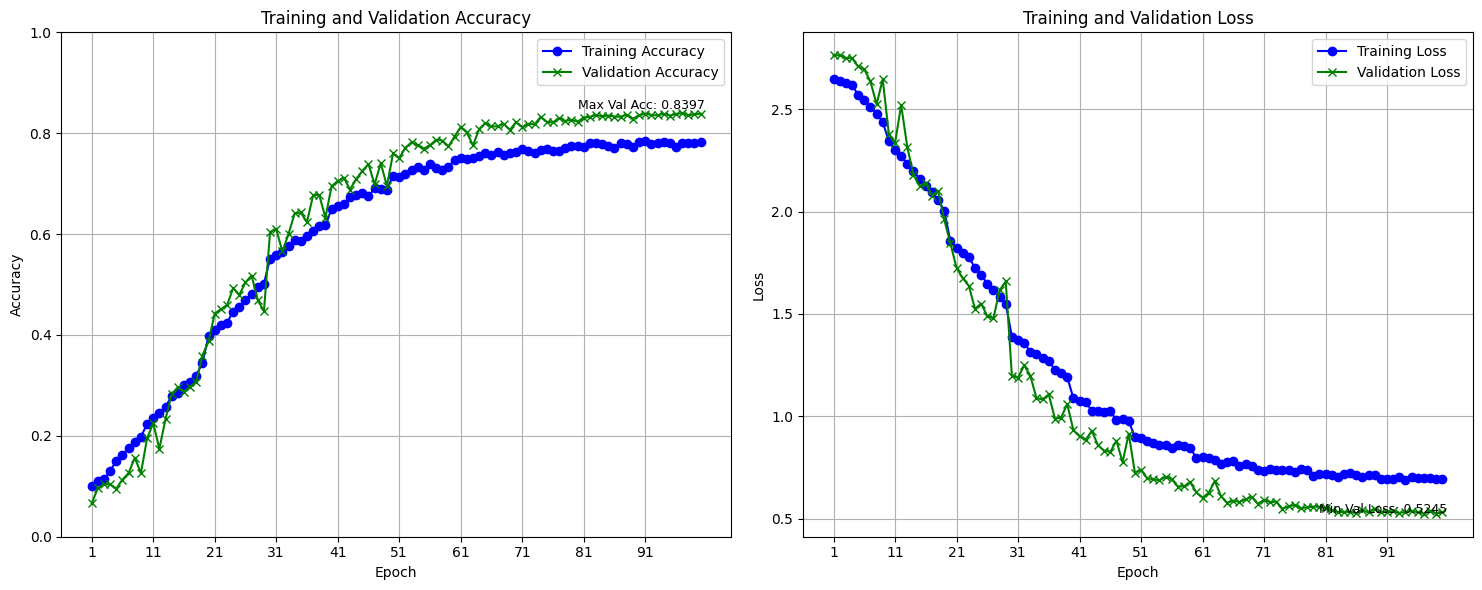

In [34]:
reset_model(adapted_alexnet_model)
train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

N_STEPS = train_gen.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

alexnet = instantiate_alexnet_model(INPUT_SHAPE_128)

alexnet_history = alexnet.fit(
    train_gen,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(alexnet_history, description="128x128")
plot_history(alexnet_history)

AlexNet performs great on the 128x128 image size, with the validation accuracy and loss closely following training results. It reached a peak max validation accuracy of `0.84`. 

This model is capable of generalizing to the larger image size so well that validation results consistently performed better than training accuracy.

Though the results are amazing, I think we can further improve validation accuracy with an even better model.

#### **AlexNet (31x31)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
282/282 [==============================] - 13s 44ms/step - loss: 2.6502 - accuracy: 0.1014 - val_loss: 2.7692 - val_accuracy: 0.0655 - lr: 0.1000
Epoch 2/100
282/282 [==============================] - 12s 44ms/step - loss: 2.6410 - accuracy: 0.0999 - val_loss: 2.7715 - val_accuracy: 0.0669 - lr: 0.1000
Epoch 3/100
282/282 [==============================] - 12s 44ms/step - loss: 2.6390 - accuracy: 0.1028 - val_loss: 2.7813 - val_accuracy: 0.0665 - lr: 0.1000
Epoch 4/100
282/282 [==============================] - 12s 44ms/step - loss: 2.6372 - accuracy: 0.1020 - val_loss: 2.7865 - val_accuracy: 0.0662 - lr: 0.1000
Epoch 5/100
282/282 [==============================] - 12s 43ms/step - loss: 2.6371 - accuracy: 0.1038 - val_loss: 2.7788 - val_accuracy: 0.0672 - lr: 0.1000
Epoch 6/100
282/282 [==============================] - 12s 44ms/step - loss: 2.6371 - 

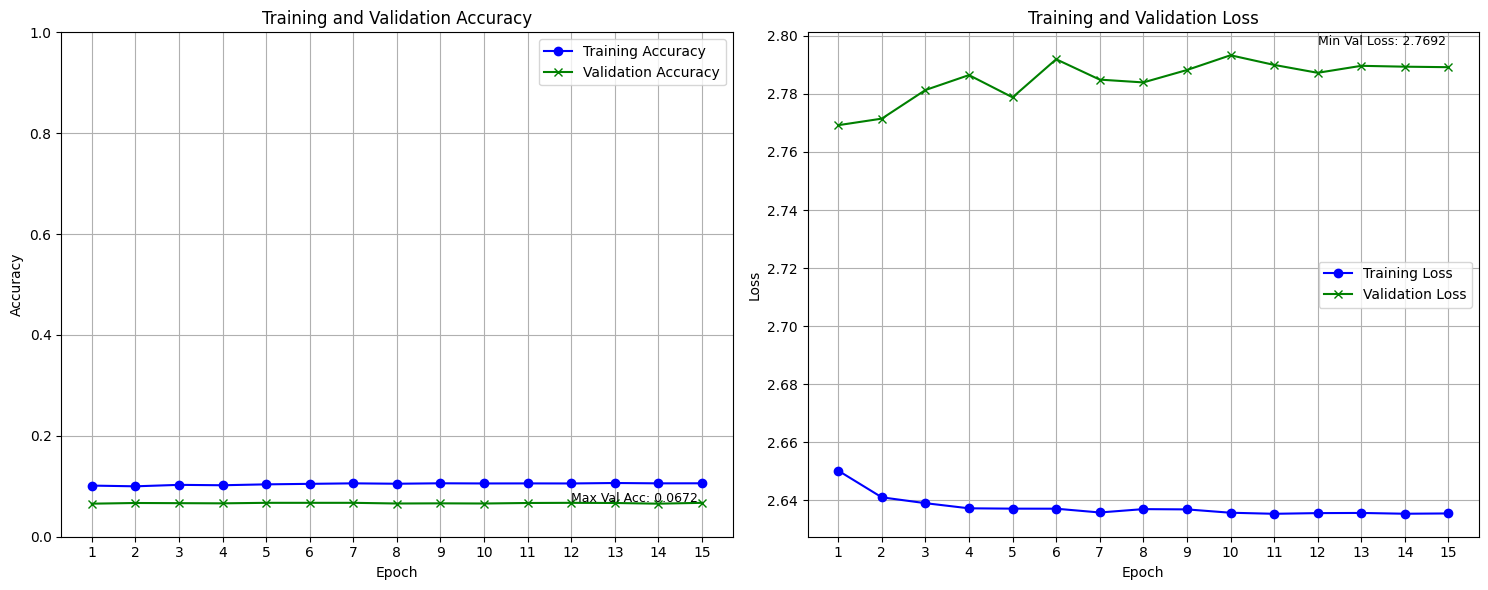

In [63]:
train_gen = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

N_STEPS = train_gen.samples // BATCH_SIZE
N_VAL_STEPS = valid_gen.samples // BATCH_SIZE
N_EPOCHS = 100

alexnet = instantiate_alexnet_model(INPUT_SHAPE_31)

alexnet_history = alexnet.fit(
    train_gen,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
    validation_data=valid_gen,
    validation_steps=N_VAL_STEPS,
)

storeResult(alexnet_history, description="31x31")
plot_history(alexnet_history)

AlexNet did terrible with the 31x31 images. 

This is likely because the 31x31 image size is so small that the 11x11 filter size of AlexNet could not capture details from the image. There was absolutely no change in the accuracy during training. This tells me that smaller images require smaller filter sizes.

### **ADAPTED VGG-16 MODEL**

VGG16 is a convolutional neural network model that’s used for image recognition. It’s unique in that it has only 16 layers that have weights, as opposed to relying on a large number of hyper-parameters. It’s considered one of the best vision model architectures.

VGG16 improves on AlexNet and **replaces the large filters with sequences of smaller 3×3 filters**. In AlexNet, the kernel size is 11 for the first convolutional layer and 5 for the second layer.

VGG16 was originally used with a 224x224 image input size. I do expect VGG to work well on our larger image size, 128x128, due to its deep architecture.

I would not be surprised if it worked with the 31x31 image size as well due to its small 3x3 filter, allowing the model to capture details from tiny images.

![VGG-16 visualized](https://datagen.tech/wp-content/uploads/2022/11/image2-1.png)


**VGG block**

VGG is made up of repeating blocks of Convolution + ReLU + Max Pooling


In [64]:
def vgg_block(num_conv, num_channels):
    blk = Sequential()
    for _ in range(num_conv):
        blk.add(Conv2D(num_channels, kernel_size=3, padding="same", activation="relu"))
        blk.add(BatchNormalization())
        blk.add(MaxPooling2D(pool_size=2, strides=2, padding="same"))
    return blk

In [65]:
def instantiate_vgg_model(input_shape):
    inputs = Input((*input_shape, 1))  # Input
    x = inputs
    x = vgg_block(2, 16)(x)  # Less filters compared to VGG16
    x = vgg_block(2, 32)(x)
    x = vgg_block(2, 64)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, "relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(NUM_CLASSES, "softmax")(x)
    vgg_model = Model(inputs=inputs, outputs=x, name="vgg_model")
    vgg_model.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return vgg_model


vgg_model = instantiate_vgg_model(DEFAULT_SHAPE)
vgg_model.summary()

Model: "vgg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 56, 56, 16)        2608      
                                                                 
 sequential_1 (Sequential)   (None, 14, 14, 32)        14144     
                                                                 
 sequential_2 (Sequential)   (None, 4, 4, 64)          55936     
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                         

#### **VGG (128x128)**
Trained on augmented data

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 23s 78ms/step - loss: 2.5797 - accuracy: 0.1447 - val_loss: 3.3036 - val_accuracy: 0.0940 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 22s 76ms/step - loss: 2.4144 - accuracy: 0.1927 - val_loss: 5.9791 - val_accuracy: 0.0603 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 22s 77ms/step - loss: 2.1770 - accuracy: 0.2836 - val_loss: 2.2778 - val_accuracy: 0.2843 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 22s 78ms/step - loss: 1.9728 - accuracy: 0.3458 - val_loss: 3.3628 - val_accuracy: 0.2407 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 22s 78ms/step - loss: 1.9288 - accuracy: 0.3716 - val_loss: 2.1164 - val_accuracy: 0.2667 - lr: 0.1000
Epoch 6/100
283/283 [==============================] - 21s 74ms/step - loss: 1.8312 - 

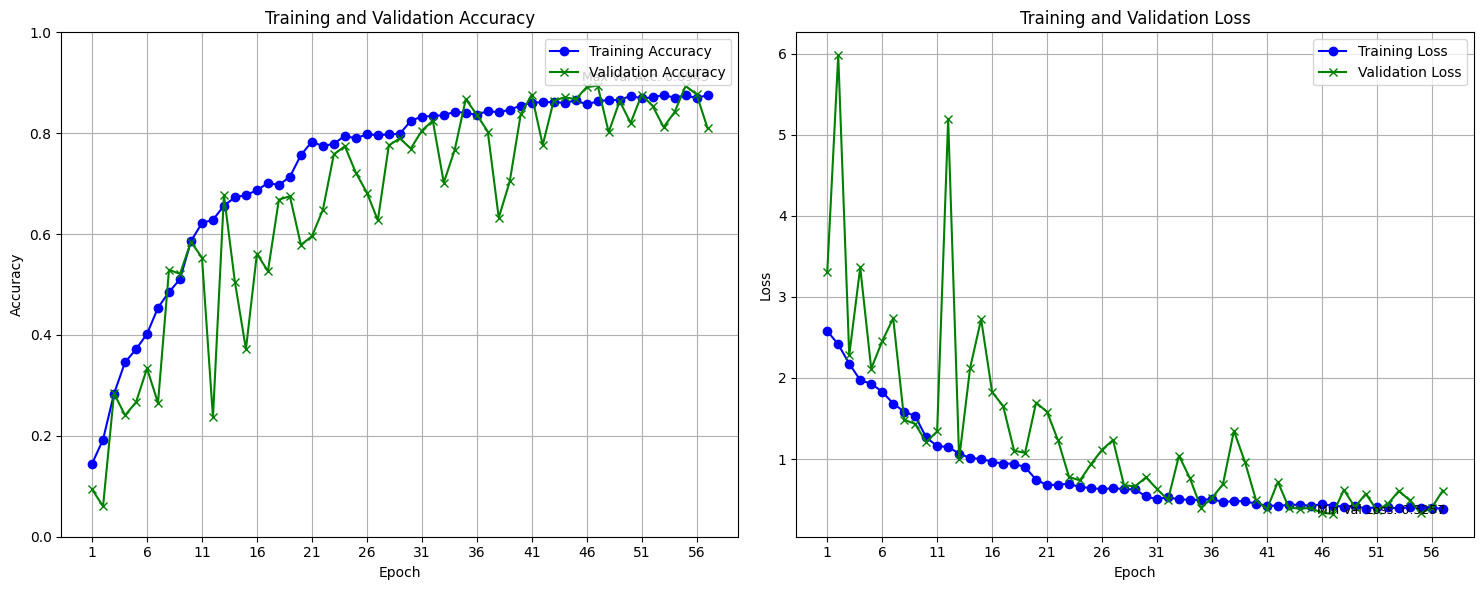

In [68]:
reset_model(vgg_model)
train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

vgg_model = instantiate_vgg_model(INPUT_SHAPE_128)
vgg_model_augmented_history = vgg_model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)

storeResult(
    vgg_model_augmented_history, description="128x128"
)
plot_history(vgg_model_augmented_history)

VGG achieved even higher accuracy (`89%`) than AlexNet on the 128x128 images. However validation results seem to fluctuate which may indicate some overfitting. I will be trying to use regularization to fix this issue. 

#### **VGG (31x31)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 11s 38ms/step - loss: 2.2092 - accuracy: 0.2868 - val_loss: 2.5744 - val_accuracy: 0.2040 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 10s 36ms/step - loss: 1.7678 - accuracy: 0.4261 - val_loss: 4.1188 - val_accuracy: 0.2040 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 10s 37ms/step - loss: 1.5763 - accuracy: 0.5049 - val_loss: 1.9836 - val_accuracy: 0.4100 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 11s 37ms/step - loss: 1.4445 - accuracy: 0.5541 - val_loss: 1.3604 - val_accuracy: 0.5773 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 11s 37ms/step - loss: 1.3667 - accuracy: 0.5841 - val_loss: 3.5963 - val_accuracy: 0.2430 - lr: 0.1000
Epoch 6/100
283/283 [==============================] - 11s 37ms/step - loss: 1.2448 - 

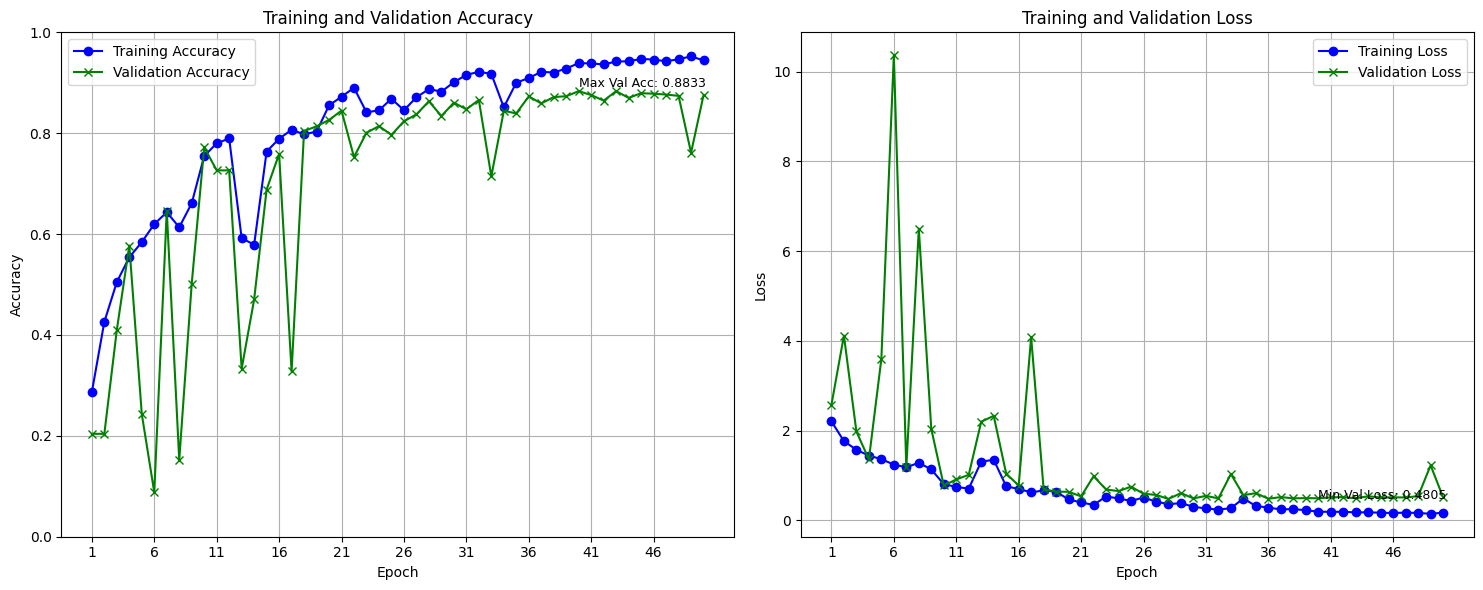

In [69]:
reset_model(vgg_model)
train_gen = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

vgg_model = instantiate_vgg_model(INPUT_SHAPE_31)
vgg_model_augmented_history = vgg_model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)

storeResult(
    vgg_model_augmented_history, description="31x31"
)
plot_history(vgg_model_augmented_history)

VGG worked great on our 31x31 image size. This is a large contrast from AlexNet, likely due to its small 3x3 filter size and deeper layers, which allowed it to analyze the tiny 31x31 images. 

Even though VGG was made for larger models, it still worked great for smaller image sizes (`88.3%`), albeit not as well.

##### **L2 & L1 Regularization**

L1 and L2 are the most common types of regularization. These update the general cost function by adding another term known as the regularization term.

Due to the addition of this regularization term, the values of weight matrices decrease because it assumes that a neural network with smaller weight matrices leads to simpler models. Therefore, it will also reduce overfitting to quite an extent.

However, this regularization term differs in L1 and L2.


**In L2, we have**

Here, lambda (λ) is the regularization parameter. It is the hyperparameter whose value is optimized for better results. L2 regularization is also known as weight decay as it forces the weights to decay towards zero (but not exactly zero).

**In L1, we have**

In this, we penalize the absolute value of the weights. Unlike L2, the weights may be reduced to zero here.

Hence, it is very useful when we are trying to compress our model. Otherwise, **we usually prefer L2 over it**.

Source: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/


#### **VGG-16 L2**

In [17]:
def vgg_block_l2(num_conv, num_channels, regularization_factor=0.0001):
    blk = Sequential()
    for _ in range(num_conv):
        blk.add(
            Conv2D(
                num_channels,
                kernel_size=3,
                padding="same",
                activation="relu",
                kernel_regularizer=regularizers.l2(regularization_factor),
            )
        )
        blk.add(BatchNormalization())
        blk.add(MaxPooling2D(pool_size=2, strides=2, padding="same"))
    return blk

In [44]:
def instantiate_vgg_l2_model(input_shape):
    inputs = Input((*input_shape, 1))  # Input
    x = inputs
    x = vgg_block_l2(2, 16)(x)  # Less filters compared to VGG16
    x = vgg_block_l2(2, 32)(x)
    x = vgg_block_l2(2, 64)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, "relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(NUM_CLASSES, "softmax")(x)
    vgg_l2 = Model(inputs=inputs, outputs=x, name="vgg_l2")
    vgg_l2.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return vgg_l2


vgg_l2 = instantiate_vgg_l2_model(DEFAULT_SHAPE)
vgg_l2.summary()

Model: "vgg_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 56, 56, 16)        2608      
                                                                 
 sequential_4 (Sequential)   (None, 14, 14, 32)        14144     
                                                                 
 sequential_5 (Sequential)   (None, 4, 4, 64)          55936     
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                            

#### **VGG With L2 (128x128)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 30s 73ms/step - loss: 2.4795 - accuracy: 0.2037 - val_loss: 5.1245 - val_accuracy: 0.0773 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 15s 54ms/step - loss: 2.0981 - accuracy: 0.3254 - val_loss: 7.7313 - val_accuracy: 0.1187 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 15s 54ms/step - loss: 1.8874 - accuracy: 0.3969 - val_loss: 2.3840 - val_accuracy: 0.3667 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 16s 57ms/step - loss: 1.8034 - accuracy: 0.4366 - val_loss: 2.6015 - val_accuracy: 0.3187 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 18s 62ms/step - loss: 1.7105 - accuracy: 0.4736 - val_loss: 1.7874 - val_accuracy: 0.4493 - lr: 0.1000
Epoch 6/100
283/283 [==============================] - 18s 62ms/step - loss: 1.6498 - 

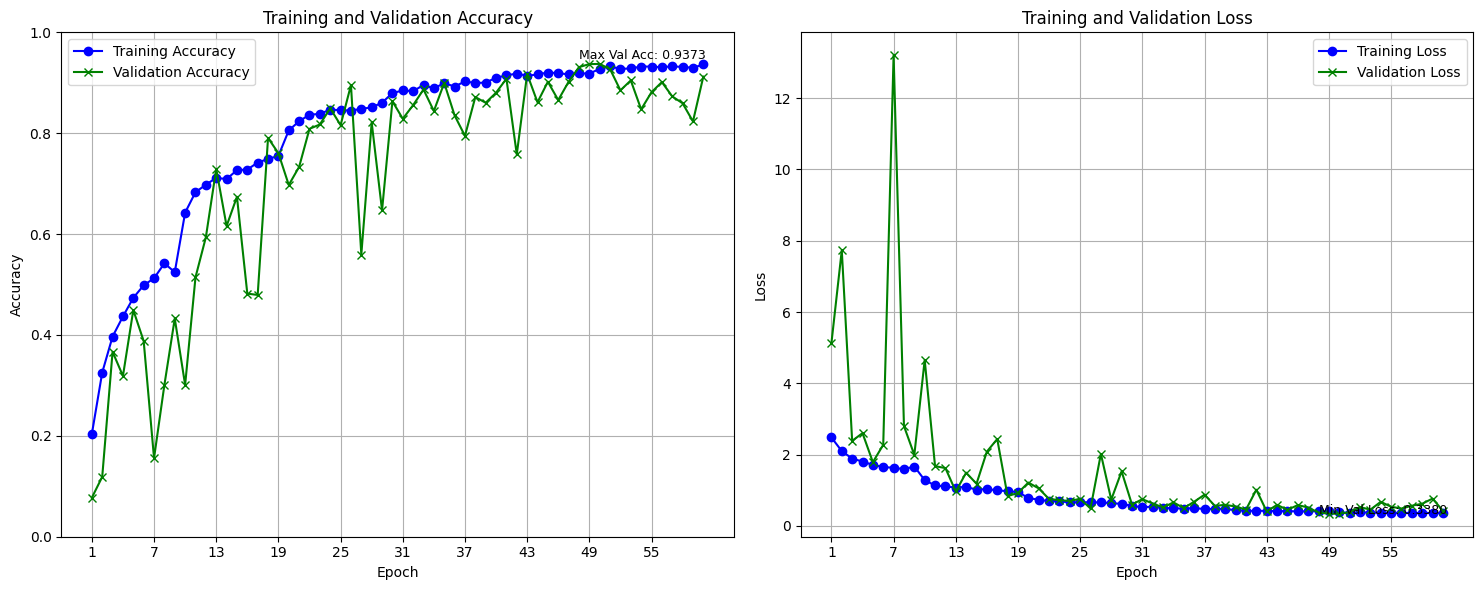

In [45]:
reset_model(vgg_l2)

train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

vgg_l2 = instantiate_vgg_l2_model(INPUT_SHAPE_128)
vgg_l2_history = vgg_l2.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)
vgg_l2.save("128x128_vgg_l2.keras")
storeResult(vgg_l2_history, description="128x128 with L2")
plot_history(vgg_l2_history)

L2 regularization managed to fix the drop in training and validation accuracy earlier between 34 to 37 epochs. It was even able to get a higher max validation accuracy of `95.9%`. However before 25 epochs, training was extremely volatile. This could be due to the new regularization parameter `(λ)` introduced, whose value has not had time to be optimized for better results. Over time, we can see that it has significantly regularized training to be more consistent and regular.

#### **VGG With L2 (31x31)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 8s 27ms/step - loss: 2.1745 - accuracy: 0.3386 - val_loss: 2.9629 - val_accuracy: 0.2647 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 7s 26ms/step - loss: 1.8153 - accuracy: 0.4603 - val_loss: 1.8080 - val_accuracy: 0.4793 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 7s 25ms/step - loss: 1.6583 - accuracy: 0.5233 - val_loss: 2.5032 - val_accuracy: 0.3950 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 7s 26ms/step - loss: 1.4997 - accuracy: 0.5865 - val_loss: 7.4152 - val_accuracy: 0.1490 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 7s 26ms/step - loss: 1.5149 - accuracy: 0.6006 - val_loss: 1.9868 - val_accuracy: 0.5513 - lr: 0.1000
Epoch 6/100
283/283 [==============================] - 7s 26ms/step - loss: 1.4734 - accura

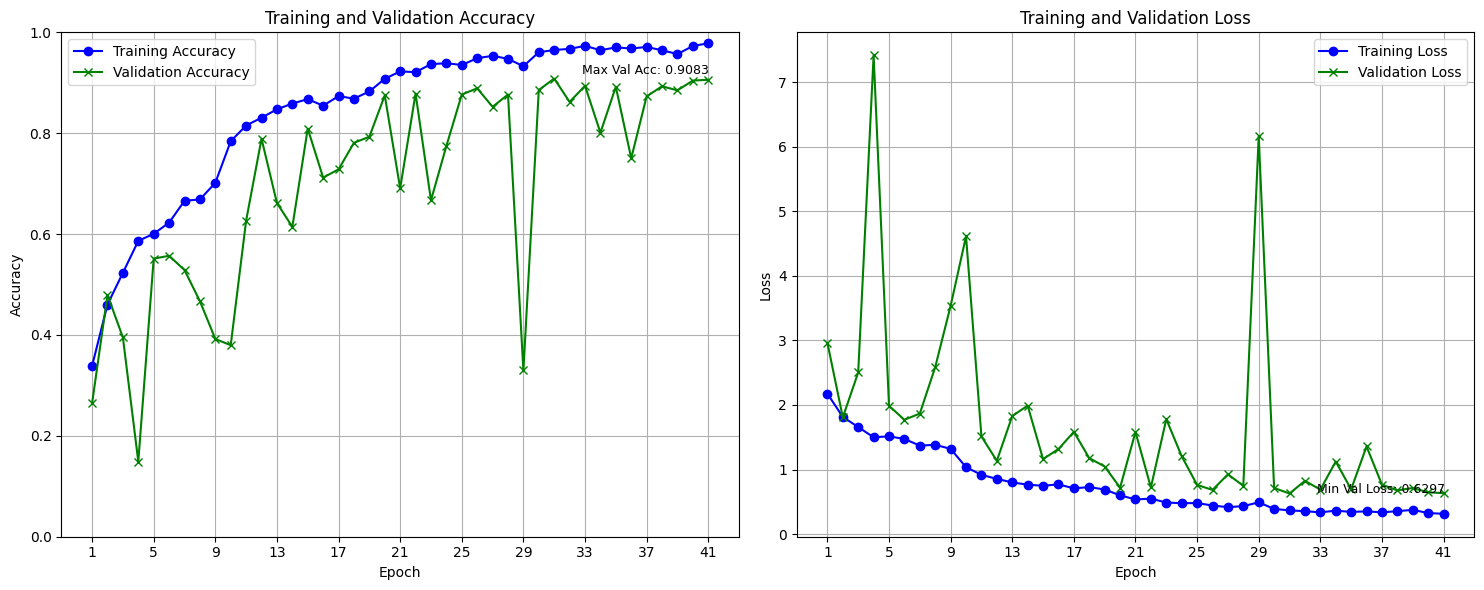

In [52]:
reset_model(vgg_l2)

train_gen = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

vgg_l2 = instantiate_vgg_l2_model(INPUT_SHAPE_31)
vgg_l2_history = vgg_l2.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)
vgg_l2.save("31x31_vgg_l2.keras")
storeResult(vgg_l2_history, description="31x31 with L2")
plot_history(vgg_l2_history)

L2 regularization managed to fix the abnormal drop in training and validation accuracy earlier around 33 to 48 epochs. It was even able to get a higher max validation accuracy of `91.2%`. However before 25 epochs, training was extremely volatile. This could be due to the new regularization parameter `(λ)` introduced, whose value has not had time to be optimized for better results. Over time, we can see that it has significantly regularized training to be more consistent and regular.

**Adapted VGG Takeaways**

This model was able to work with both large and small image sizes after changing the number of filters and blocks from the original VGG-16 model that was made for 224x224 image sizes. 

Smaller kernel sizes allow CNNs to capture more details in an image, thus improving validation results. Smaller kernel sizes also work for both large and small images, whereas large kernel sizes are terrible for small images.

### **ADAPTED ResNet18 MODEL**

**ResNet**, short for Residual Networks, is a classic neural network used in the field of deep learning, particularly in image recognition and computer vision. It was introduced by Kaiming He et al. in their 2015 paper, "Deep Residual Learning for Image Recognition." The key innovation of ResNet is the introduction of "residual blocks" with skip connections.

ResNet's main feature compared to VGG is its use of residual blocks. These blocks allow the network to skip one or more layers, using a so-called "skip connection" or "shortcut connection." This helps in addressing the vanishing gradient problem by allowing the gradient to flow through the network more effectively during training.

ResNet18 was built for small images. It was trained on images 32x32. I expect it to perform better on 31x31 than on 128x128.


<img src="https://www.researchgate.net/publication/343957273/figure/fig2/AS:930467717083136@1598852199057/ResNet-18-architecture-used-in-the-proposed-method-Res-block1-is-a-regular-ResNet-block.png" width="700"/>

In [74]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False, regularization=None):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__regularization = regularization
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(
            self.__channels,
            strides=self.__strides[0],
            kernel_size=KERNEL_SIZE,
            padding="same",
            kernel_initializer=INIT_SCHEME,
            kernel_regularizer=self.__regularization,
        )
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(
            self.__channels,
            strides=self.__strides[1],
            kernel_size=KERNEL_SIZE,
            padding="same",
            kernel_initializer=INIT_SCHEME,
            kernel_regularizer=self.__regularization,
        )
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            self.res_conv = Conv2D(
                self.__channels,
                strides=2,
                kernel_size=(1, 1),
                kernel_initializer=INIT_SCHEME,
                kernel_regularizer=self.__regularization,
                padding="same",
            )
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [75]:
class ResNet18(Model):
    def __init__(self, num_classes, regularizer, **kwargs):
        """
        num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(
            64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal"
        )
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64, regularization=regularizer)
        self.res_1_2 = ResnetBlock(64, regularization=regularizer)
        self.res_2_1 = ResnetBlock(128, down_sample=True, regularization=regularizer)
        self.res_2_2 = ResnetBlock(128, regularization=regularizer)
        self.res_3_1 = ResnetBlock(256, down_sample=True, regularization=regularizer)
        self.res_3_2 = ResnetBlock(256, regularization=regularizer)
        self.res_4_1 = ResnetBlock(512, down_sample=True, regularization=regularizer)
        self.res_4_2 = ResnetBlock(512, regularization=regularizer)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [
            self.res_1_1,
            self.res_1_2,
            self.res_2_1,
            self.res_2_2,
            self.res_3_1,
            self.res_3_2,
            self.res_4_1,
            self.res_4_2,
        ]:
            out = res_block(out)
            
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [76]:
def instantiate_resnet18_model(input_shape, regularizer=None):
    resnet_18_model = ResNet18(NUM_CLASSES, regularizer)
    resnet_18_model.build(input_shape = (None,*input_shape,1))
    resnet_18_model.compile(optimizer=SGD(learning_rate=0.1,momentum=0.9),loss='categorical_crossentropy', metrics=["accuracy"]) 
    return resnet_18_model

resnet18_model = instantiate_resnet18_model(DEFAULT_SHAPE)
resnet18_model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           multiple                  3200      
                                                                 
 batch_normalization_6 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block (ResnetBlock)  multiple          

#### **ResNet (128x128)**
Trained on augmented data

Found 9028 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 27s 88ms/step - loss: 3.1770 - accuracy: 0.1442 - val_loss: 8.8415 - val_accuracy: 0.0647 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 24s 85ms/step - loss: 2.3586 - accuracy: 0.2180 - val_loss: 3.0284 - val_accuracy: 0.0797 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 24s 86ms/step - loss: 2.0979 - accuracy: 0.3004 - val_loss: 3.6925 - val_accuracy: 0.0613 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 24s 86ms/step - loss: 1.8637 - accuracy: 0.3776 - val_loss: 5.2398 - val_accuracy: 0.0620 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 24s 86ms/step - loss: 1.7073 - accuracy: 0.4274 - val_loss: 5.0175 - val_accuracy: 0.0740 - lr: 0.0500
Epoch 6/100
283/283 [==============================] - 24s 86ms/step - loss: 1.4836 - accuracy: 0.5042 - val_loss: 8.0683 - val_accuracy: 0.0693 - l

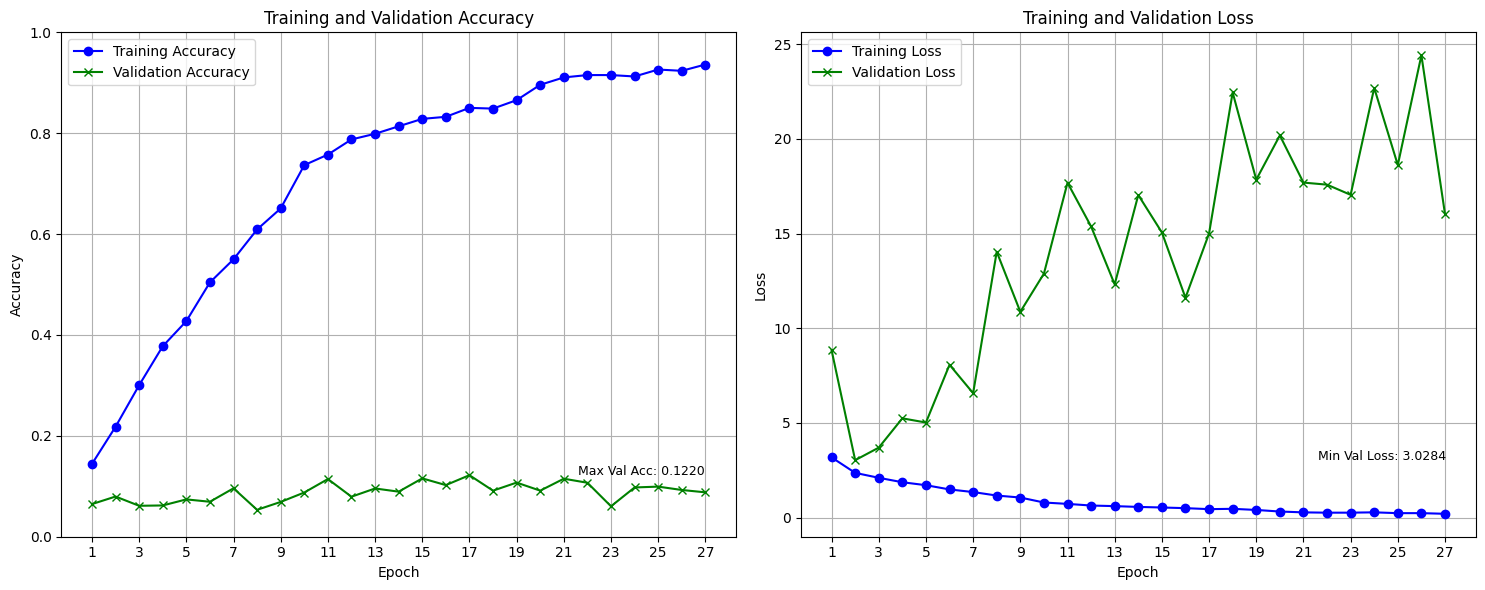

In [77]:
train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

resnet18_model = instantiate_resnet18_model(INPUT_SHAPE_128)
resnet18_model_history = resnet18_model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)

storeResult(resnet18_model_history, description="128x128")
plot_history(resnet18_model_history)

ResNet18 performed terribly on our 128x128 image sizes despite the use of a small kernel size. Validation accuracy did not improve at all, while training accuracy is sky high. In fact validation loss was consistently increasing after 1 epoch. This tells me that larger models may work for small images, but smaller models likely wont work with images sizes too big for it. 

Resnet18 has too few residual blocks to get more information from the 128x128 images, which caused it to overfit very quickly.

#### **ResNet (31x31)**

Found 9028 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 14s 43ms/step - loss: 3.3681 - accuracy: 0.1490 - val_loss: 2.5861 - val_accuracy: 0.1613 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 12s 41ms/step - loss: 2.2763 - accuracy: 0.2538 - val_loss: 2.4196 - val_accuracy: 0.1897 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 12s 41ms/step - loss: 2.1156 - accuracy: 0.3161 - val_loss: 2.1690 - val_accuracy: 0.3083 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 11s 41ms/step - loss: 1.9035 - accuracy: 0.3941 - val_loss: 2.5066 - val_accuracy: 0.3107 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 11s 40ms/step - loss: 1.6323 - accuracy: 0.4821 - val_loss: 2.2986 - val_accuracy: 0.3300 - lr: 0.1000
Epoch 6/100
283/283 [==============================] - 12s 41ms/step - loss: 1.4065 - accuracy: 0.5569 - val_loss: 3.1921 - val_accuracy: 0.2200 - l

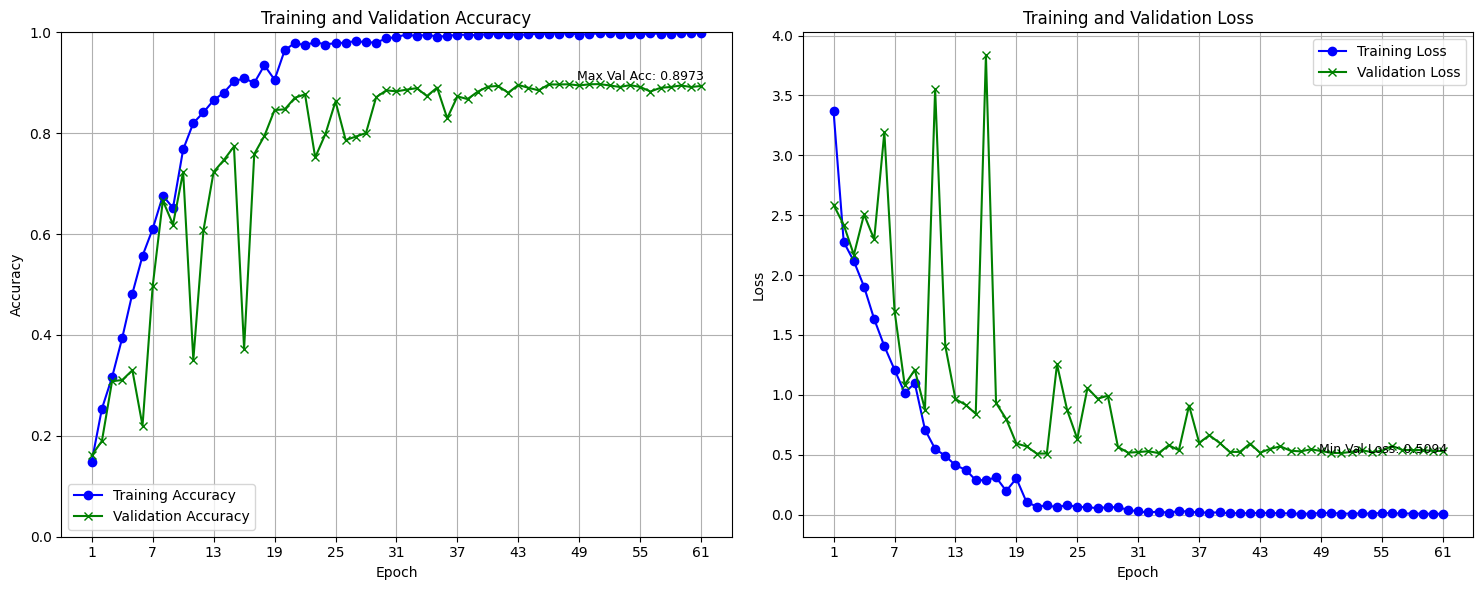

In [78]:
train_gen = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

resnet18_model = instantiate_resnet18_model(INPUT_SHAPE_31)
resnet18_model_history = resnet18_model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)

storeResult(resnet18_model_history, description="31x31")
plot_history(resnet18_model_history)

Compared to VGG, ResNet18 performed very similarly. However the difference between training and validation accuracy looks larger here than in VGG. Lets use L2 regularization to see if it helps.

#### **ResNet With L2 (31x31)**

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 15s 45ms/step - loss: 5.1911 - accuracy: 0.1891 - val_loss: 4.6330 - val_accuracy: 0.1693 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 12s 41ms/step - loss: 4.1005 - accuracy: 0.2473 - val_loss: 4.2778 - val_accuracy: 0.1787 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 12s 41ms/step - loss: 3.7107 - accuracy: 0.3181 - val_loss: 3.6172 - val_accuracy: 0.2987 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 12s 41ms/step - loss: 3.3584 - accuracy: 0.3819 - val_loss: 3.8698 - val_accuracy: 0.2700 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 12s 41ms/step - loss: 2.9639 - accuracy: 0.4689 - val_loss: 3.1013 - val_accuracy: 0.4040 - lr: 0.1000
Epoch 6/100
283/283 [==============================] - 12s 41ms/step - loss: 2.5382 - 

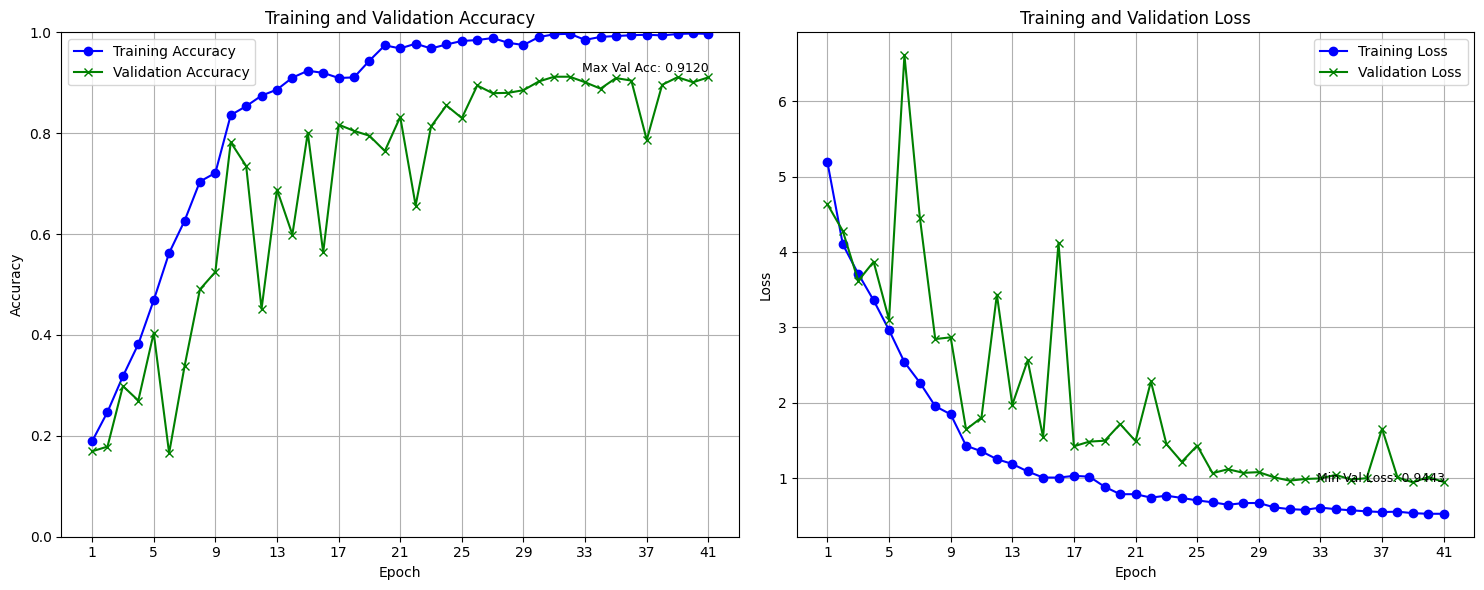

In [79]:
train_gen = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

adapted_resnet18_l2 = instantiate_resnet18_model(
    INPUT_SHAPE_31, regularizer=regularizers.l2(0.0001)
)
adapted_resnet18_l2_augmented_history = adapted_resnet18_l2.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)
adapted_resnet18_l2.save("31x31_resnet18_l2.keras")
storeResult(adapted_resnet18_l2_augmented_history, description="31x31 With L2")
plot_history(adapted_resnet18_l2_augmented_history)

L2 regularization increased the max validation accuracy to (`91.2%`), which is the same as VGG with L2. However, the validation accuracy results from ResNet18 are more haphazard and flunctuating. Which is why VGG would be a better pick.

ResNet18 manage to achieve the same accuracy as VGG, more than **20 epochs faster**. This demonstrates the work of skip connections in ResNet, allowing the model to converge faster, and opening doors to even deeper neural networks.

## **MODEL SELECTION**

Let's pick the best performing model from the different image sizes to be fine tuned

In [97]:
allResults.to_pickle("allResults")
allResults.sort_values(by=["Val Acc"], ascending=False)

Model Name           Description  Epochs  Batch Size  Train Loss  \
14       vgg_l2       128x128 with L2      53          32    0.421230   
15       vgg_l2         31x31 with L2      64          32    0.285923   
18  res_net18_3         31x31 With L2      41          32    0.589346   
17  res_net18_2                 31x31      61          32    0.008974   
12    vgg_model               128x128      57          32    0.424421   
13    vgg_model                 31x31      50          32    0.194910   
5    base_model      31x31 imbalanced      35          32    0.064733   
6    base_model     128x128 augmented      35          32    0.064733   
1    base_model     31x31 oversampled      21          32    0.376571   
10      alexnet               128x128      80          32    1.090381   
3    base_model    31x31 undersampled      47          32    0.146421   
0    base_model   128x128 oversampled      28          32    0.000860   
4    base_model    128x128 imbalanced      26          32    0.008087   
2    base_model  128x128 undersampled      15          32    0.981946   
7    base_model       31x31 augmented      38          32    1.652369   
16  res_net18_1               128x128      27          32    0.441967   
9       alexnet               128x128      11          32    2.651931   
11      alexnet                 31x31      15          32    2.637116   
8       alexnet               128x128      15          32    2.636989   

     Val Loss  Train Acc   Val Acc  [Train - Val] Acc  
14   0.441748   0.919251  0.919000           0.000251  
15   0.724862   0.987262  0.912333           0.074929  
18   0.966771   0.996123  0.912000           0.084123  
17   0.513809   0.998006  0.897333           0.100673  
12   0.325744   0.863314  0.894333          -0.031019  
13   0.494621   0.938968  0.883333           0.055634  
5    0.905352   0.993553  0.786290           0.207262  
6    0.905352   0.993553  0.786290           0.207262  
1    0.929273   0.892325  0.741599           0.150725  
10   0.911680   0.642397  0.693884          -0.051488  
3    1.272373   0.977766  0.686492           0.291274  
0    2.994822   1.000000  0.631048           0.368952  
4    3.998235   0.999444  0.596102           0.403342  
2    1.703261   0.709870  0.520833           0.189037  
7    1.647656   0.466985  0.487231          -0.020246  
16  15.004394   0.850244  0.122000           0.728244  
9    2.769775   0.096932  0.073925           0.023007  
11   2.778830   0.103824  0.067204           0.036620  
8    2.792042   0.103713  0.067204           0.036508

VGG with L2 achieved the highest validation accuracy for both 128x128 and 31x31 image sizes

## **MODEL IMPROVEMENT**
Best 128x128 model = **VGG With L2 (128x128)**

Best 31x31 model = **VGG With L2 (31x31)**

### VGGHyperModel

##### **Defining the Model with Hyperparameters**
Hyperparameters under tuning 
1. Number of Convolutional Blocks
2. Number of Filters per Convolutional Block
3. Kernel Size in Convolutional Layers
4. Batch Normalization
5. Number of Dense Layers
6. Units in Dense Layers
7. Activation Function in Dense Layers
8. L2 Regularization in Dense Layers
9. Dropout Rate
10. Optimizer Type
11. Learning Rate

In [11]:
class VGGHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes, **kwargs):
        self.input_shape = input_shape
        self.num_classes = num_classes
        super().__init__(**kwargs)

    def build(self, hp):
        inputs = Input((*self.input_shape, 1))
        x = inputs

        # Tuning the number of convolutional blocks
        num_blocks = hp.Int('num_blocks', min_value=3, max_value=4, step=1)
        for block_num in range(num_blocks):
            # Define num_filters inside the loop
            num_filters = hp.Int(
                "num_filters_block_" + str(block_num),
                min_value=16,
                max_value=128,
                step=16,
            )
            x = vgg_block_l2(
                hp.Choice('kernel_size', values=[3, 5]),
                num_filters
            )(x)
            if hp.Boolean('use_batch_norm'):
                x = BatchNormalization()(x)

        x = GlobalAveragePooling2D()(x)

        # Tuning the number of dense layers
        for _ in range(hp.Int('num_dense_layers', 1, 3)):
            x = Dense(
                hp.Int('dense_units', min_value=64, max_value=512, step=64), 
                activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'elu']),
                kernel_regularizer=tf.keras.regularizers.l2(
                    hp.Float('l2_regularization', min_value=1e-4, max_value=1e-2, sampling='LOG')
                )
            )(x)
            x = Dropout(hp.Float('dropout_rate', 0.3, 0.5, step=0.1))(x)

        x = Dense(self.num_classes, activation="softmax")(x)

        model = Model(inputs=inputs, outputs=x, name="vgg_l2")

        # Tuning the optimizer
        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        lr = hp.Float("learning_rate", min_value=1e-8, max_value=1e-2, sampling="LOG")
        if optimizer_choice == 'adam':
            optimizer = Adam(learning_rate=lr)
        elif optimizer_choice == 'sgd':
            optimizer = SGD(learning_rate=lr, momentum=0.9)
        else:
            optimizer = RMSprop(learning_rate=lr)

        model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model
    
    def model_summary(self):
        # Fixed hyperparameters to print example summary
        hp = HyperParameters()
        # Add fixed values for the new hyperparameters
        hp.Fixed('num_blocks', value=3)
        hp.Fixed('num_dense_layers', value=2)
        hp.Fixed('dense_units', value=256)
        hp.Fixed('dense_activation', value='relu')
        hp.Fixed('l2_regularization', value=1e-4)
        hp.Fixed('dropout_rate', value=0.4)
        hp.Fixed('optimizer', value='adam')
        hp.Fixed('learning_rate', value=1e-4)
        hp.Fixed('kernel_size', value=3)
        hp.Fixed('use_batch_norm', value=True)
        # Existing fixed hyperparameters
        for block_num in range(3):  # Assuming 3 blocks as fixed value
            hp.Fixed('num_filters_block_' + str(block_num), value=16 + block_num * 16)
        model = self.build(hp)
        model.summary()

## **Best Model 128x128**

In [12]:
# Instantiate the hypermodel
hypermodel = VGGHyperModel(input_shape=INPUT_SHAPE_128, num_classes=NUM_CLASSES)

# Instantiate the tuner
model_128x128_tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,
    directory='hyperparameter_dir',  # Directory to save logs and models
    project_name='vgg_tuning_128'
)

train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

# Perform the hyperparameter search
K.clear_session()
model_128x128_tuner.search(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stop, reduce_lr, model_checkpoint('best_128_weights.h5')])

Trial 10 Complete [02h 51m 15s]
val_accuracy: 0.06866666674613953

Best val_accuracy So Far: 0.45399999618530273
Total elapsed time: 1d 12h 35m 43s


Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 293s 1s/step - loss: 98.9114 - accuracy: 0.0762 - val_loss: 94.6637 - val_accuracy: 0.0617 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 276s 975ms/step - loss: 100.9999 - accuracy: 0.0749 - val_loss: 107.5512 - val_accuracy: 0.0667 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 276s 975ms/step - loss: 93.6103 - accuracy: 0.0720 - val_loss: 93.1570 - val_accuracy: 0.0667 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 276s 974ms/step - loss: 91.1001 - accuracy: 0.0762 - val_loss: 85.6973 - val_accuracy: 0.0667 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 280s 991ms/step - loss: 92.6721 - accuracy: 0.0776 - val_loss: 112.5749 - val_accuracy: 0.0667 - lr: 0.0500
Epoch 6/100
283/283 [==============================] - 288s 1s/step - loss: 96.7381 - accuracy: 0.0768 - val_loss: 92.2501 - val

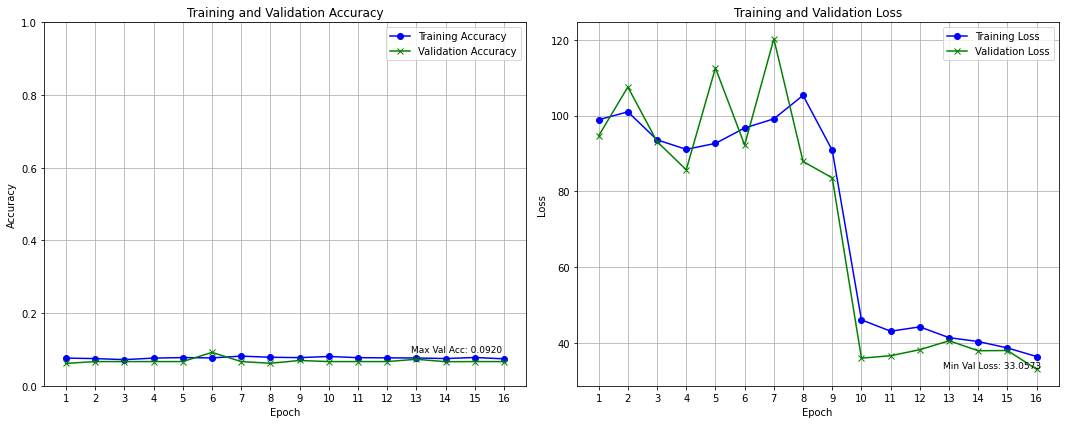

In [16]:
tf.get_logger().setLevel("ERROR")

# Get the optimal hyperparameters and model
best_hps = model_128x128_tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_128 = model_128x128_tuner.get_best_models()[0]
best_model_128.save('best_model_128.keras') # Saving best model

train_gen.reset()
valid_gen.reset()
test_gen = test_gen_format.flow_from_dataframe(
    test_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

best_model_128_history = best_model_128.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)
best_model_128.save('best_model_128.keras') # Saving best model
test_loss, test_acc = best_model_128.evaluate(test_gen)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
plot_history(best_model_128_history)

In [ ]:
test_gen.reset()
best_model_128_loaded = load_model('best_model_128.keras')
best_model_128_loaded.evaluate(test_gen)

94/94 [==============================] - 4s 40ms/step - loss: 4.9619 - accuracy: 0.0667


[4.961916446685791, 0.06666667014360428]

Results from hyperparameter tuning were terrible, likely due to the large number of hyperparameters there was to tune, and too little number of trials to cover the best ones. Lets take the model before hyperparameter tuning instead.

### Rebuild 128x128 best model

Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 28s 97ms/step - loss: 2.4434 - accuracy: 0.2185 - val_loss: 22.1164 - val_accuracy: 0.0667 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 27s 97ms/step - loss: 2.0563 - accuracy: 0.3367 - val_loss: 15.5668 - val_accuracy: 0.0740 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 27s 95ms/step - loss: 1.8885 - accuracy: 0.4061 - val_loss: 2.0388 - val_accuracy: 0.3783 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 27s 97ms/step - loss: 1.8039 - accuracy: 0.4521 - val_loss: 6.2621 - val_accuracy: 0.1873 - lr: 0.1000
Epoch 5/100
283/283 [==============================] - 27s 96ms/step - loss: 1.7138 - accuracy: 0.4825 - val_loss: 5.8137 - val_accuracy: 0.1860 - lr: 0.1000
Epoch 6/100
283/283 [==============================] - 28s 97ms/step - loss: 1.6381 

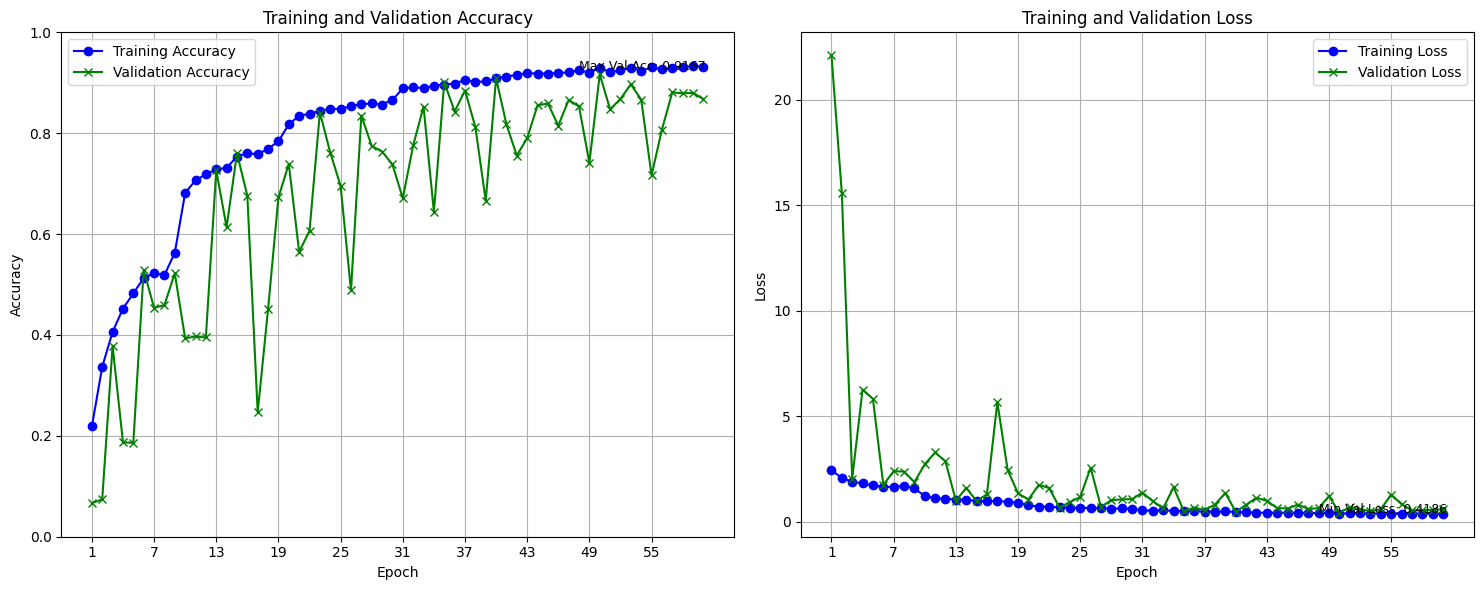

In [52]:
train_gen = train_gen_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_128)

vgg_l2 = instantiate_vgg_l2_model(INPUT_SHAPE_128)
vgg_l2_history = vgg_l2.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)
storeResult(vgg_l2_history, description="128x128 with L2")
plot_history(vgg_l2_history)
vgg_l2.save('best_model_128.keras') # Saving best model

In [58]:
test_gen.reset()
best_model_128_loaded = load_model('best_model_128.keras')
best_model_128_loaded.evaluate(test_gen)

94/94 [==============================] - 4s 43ms/step - loss: 0.4341 - accuracy: 0.9180


[0.4340760111808777, 0.9179999828338623]

Test accuracy was higher than max validation accuracy

## **Best Model 31x31**

In [25]:
# Instantiate the hypermodel
hypermodel = VGGHyperModel(input_shape=INPUT_SHAPE_31, num_classes=NUM_CLASSES)

# Instantiate the tuner
model_31x31_tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,
    directory='hyperparameter_dir',  # Directory to save logs and models
    project_name='vgg_tuning_31'
)

train_gen = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

# Perform the hyperparameter search
model_31x31_tuner.search(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stop, reduce_lr, model_checkpoint('best_31_weights')])

Trial 10 Complete [00h 06m 26s]
val_accuracy: 0.18000000715255737

Best val_accuracy So Far: 0.7643333077430725
Total elapsed time: 00h 55m 06s


Found 9028 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Epoch 1/100
283/283 [==============================] - 18s 57ms/step - loss: 3.0108 - accuracy: 0.1856 - val_loss: 3.2783 - val_accuracy: 0.1630 - lr: 0.1000
Epoch 2/100
283/283 [==============================] - 15s 54ms/step - loss: 2.7883 - accuracy: 0.2385 - val_loss: 2.9390 - val_accuracy: 0.1487 - lr: 0.1000
Epoch 3/100
283/283 [==============================] - 15s 54ms/step - loss: 2.6898 - accuracy: 0.2677 - val_loss: 3.1743 - val_accuracy: 0.1220 - lr: 0.1000
Epoch 4/100
283/283 [==============================] - 15s 55ms/step - loss: 2.6191 - accuracy: 0.3007 - val_loss: 3.7074 - val_accuracy: 0.0870 - lr: 0.0500
Epoch 5/100
283/283 [==============================] - 15s 54ms/step - loss: 2.4844 - accuracy: 0.3310 - val_loss: 4.3855 - val_accuracy: 0.0727 - lr: 0.1000
Epoch 6/100
283/283 [===

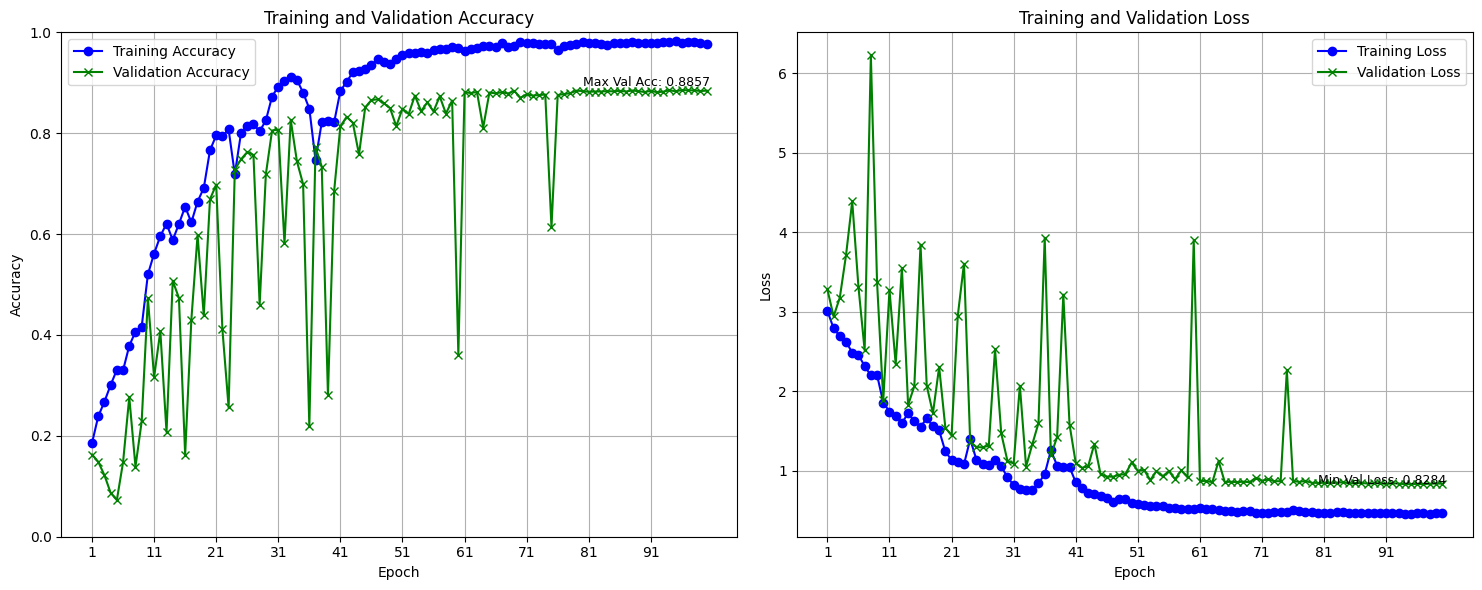

In [26]:
tf.get_logger().setLevel("ERROR")

# Get the optimal hyperparameters and model
best_hps = model_31x31_tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_31 = model_31x31_tuner.get_best_models()[0]
best_model_31.save('best_model_31.keras') # Saving best model

train_gen = train_gen_no_augment.flow_from_dataframe(
    train_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
test_gen = test_gen_format.flow_from_dataframe(
    test_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)
valid_gen = validation_generator(INPUT_SHAPE_31)

best_model_31_history = best_model_31.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        reduce_lr,
        lr_scheduler,
    ],
)
best_model_31.save('best_model_31.keras') # Saving best model
test_loss, test_acc = best_model_31.evaluate(test_gen)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
plot_history(best_model_31_history)

In [61]:
test_gen = test_gen_format.flow_from_dataframe(
    test_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

Found 3000 validated image filenames belonging to 15 classes.


In [62]:
test_gen.reset()
best_model_31_loaded = load_model('best_model_31.keras')
best_model_31_loaded.evaluate(test_gen)

94/94 [==============================] - 4s 39ms/step - loss: 0.8427 - accuracy: 0.8887


[0.8426771759986877, 0.8886666893959045]

Test accuracy was higher than max validation accuracy

# **MODEL EVALUATION**

## Best 31x31 Model

In [53]:
test_gen = test_gen_format.flow_from_dataframe(
    test_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_31,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE,
)
test_gen.class_indices

Found 3000 validated image filenames belonging to 15 classes.


{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

best_model_31_loaded = load_model('./31x31_vgg_l2.keras')
y_pred = best_model_31_loaded.predict(test_gen)
y_pred_classes = [np.argmax(element) for element in y_pred]
y_test = test_gen.classes

print(classification_report(y_test, y_pred_classes))

94/94 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       200
           1       0.93      0.91      0.92       200
           2       0.94      0.97      0.96       200
           3       0.90      0.91      0.90       200
           4       0.88      0.93      0.90       200
           5       0.93      0.83      0.88       200
           6       0.94      0.94      0.94       200
           7       0.96      0.91      0.93       200
           8       0.86      0.92      0.89       200
           9       0.95      0.94      0.95       200
          10       0.91      0.91      0.91       200
          11       0.87      0.91      0.89       200
          12       0.92      0.90      0.91       200
          13       0.94      0.90      0.92       200
          14       0.83      0.86      0.84       200

    accuracy                           0.91      3000
   macro avg       0.91   

The classification report reflects a **Balanced Dataset** with each class represented by `200` instances, ensuring no bias in model performance due to sample size disparities. The **High Accuracy** of the model stands at `0.89`, denoting its proficiency in accurately predicting the correct class. 

There is **Consistent Performance** across the board, with macro and weighted averages for precision, recall, and f1-score hovering around `0.89` to `0.90`, which points to a uniform performance across all classes. However, Class-Specific Variances are noted, as some classes like class 11 (Potato) display a lower precision of `0.72`, hinting at **possible false positives**.

The model maintains a **Good Balance between Precision and Recall**, with f1-scores being relatively high for all classes. This balance is particularly important in scenarios that are sensitive to both false positives and false negatives. 

There are potential areas for improvement; classes like class 11 (Potato) and class 14 (Tomato) exhibit lower f1-scores, signaling a need for further investigation to enhance model performance for these classes. 

Overall, the model exudes **Reliability**, with high precision, recall, and f1-score values across most classes, suggesting it is dependable for predictions in this specific domain or dataset.

## Best 128x128 Model

In [48]:
test_gen = test_gen_format.flow_from_dataframe(
    test_data,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE_128,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE,
)
test_gen.class_indices

Found 3000 validated image filenames belonging to 15 classes.


{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [50]:
from sklearn.metrics import classification_report

best_model_128_loaded = load_model('./128x128_vgg_l2.keras')
y_pred = best_model_128_loaded.predict(test_gen)
y_pred_classes = [np.argmax(element) for element in y_pred]
y_test = test_gen.classes

print(classification_report(y_test, y_pred_classes))

94/94 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       200
           1       0.95      0.95      0.95       200
           2       0.96      0.99      0.98       200
           3       0.80      0.96      0.87       200
           4       0.97      0.97      0.97       200
           5       0.89      0.92      0.90       200
           6       0.99      0.94      0.96       200
           7       0.97      0.85      0.91       200
           8       0.96      0.92      0.94       200
           9       0.96      0.94      0.95       200
          10       0.95      0.93      0.94       200
          11       0.95      0.80      0.87       200
          12       0.88      0.96      0.92       200
          13       0.96      0.93      0.95       200
          14       0.92      0.95      0.94       200

    accuracy                           0.93      3000
   macro avg       0.94   

The classification report indicates an **overall high performance** with a model accuracy of `0.92`. This suggests the model's robustness in predicting the correct classes. Precision scores are notable across all classes, with the lowest being `0.81` for class 5 (Cabbage), indicating a high likelihood of correct predictions when the model assigns a class. Similarly, recall scores are commendable, with the lowest at `0.85` for class 1 (Bitter Gourd), suggesting the model's competence in identifying the majority of positive instances for each class.

F1-scores, which represent the harmonic mean of precision and recall, are strong for all classes, signifying a well-balanced model. The support for each class is `200`, demonstrating a balanced dataset that aids in preventing class imbalance from skewing the model's performance metrics.

Both macro and weighted averages stand at `0.92` for precision, recall, and f1-score, which reflects the model's uniform performance across all classes. Despite the high scores, there might be potential for fine-tuning, especially for classes with the lowest metrics to further enhance the model's performance.